Simulation of numerical approximation of diffusion equation  with plug and Gaussian inputs, illustrating spatial and temporal evolution of concentration profiles. (FE Method)

Exact and numerical solutions are within tolerance level 1e-10
For plug input:


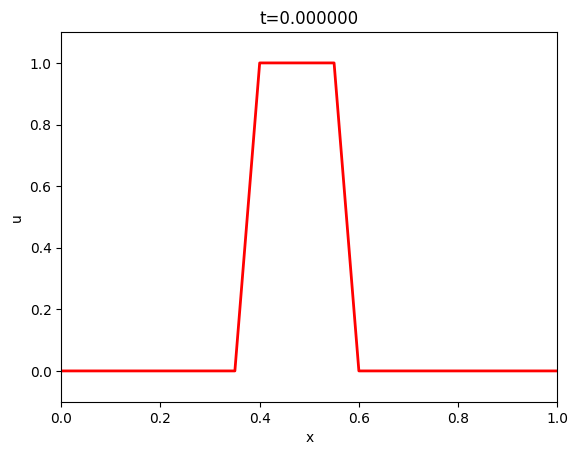

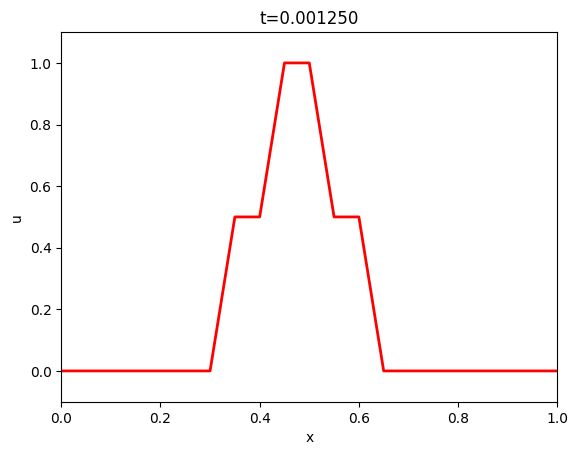

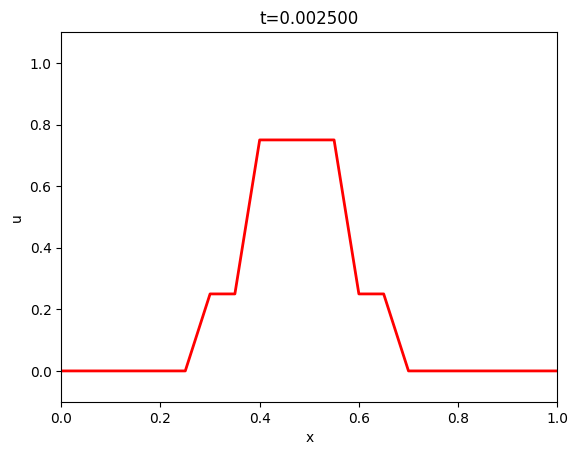

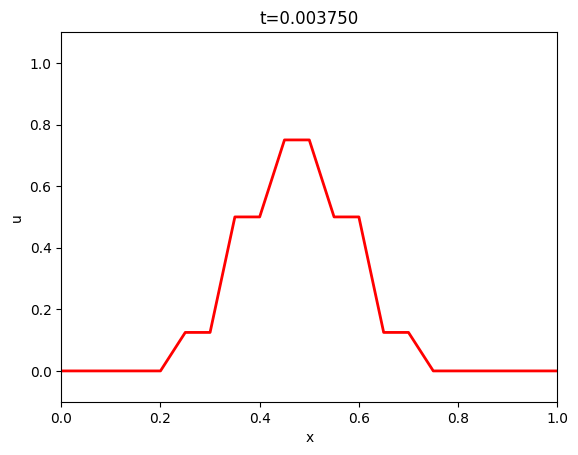

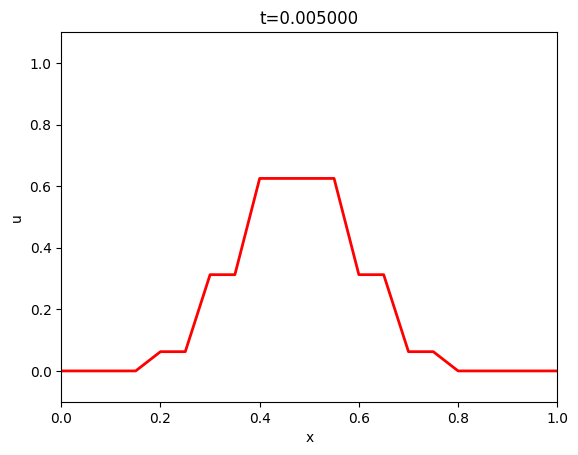

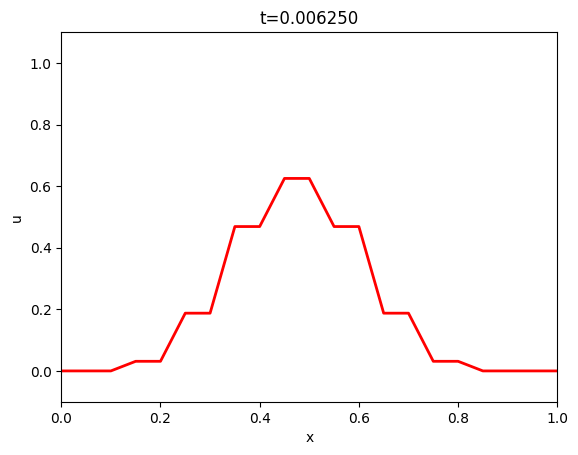

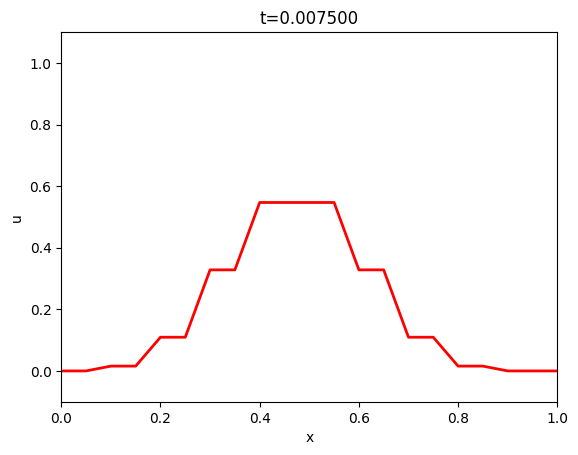

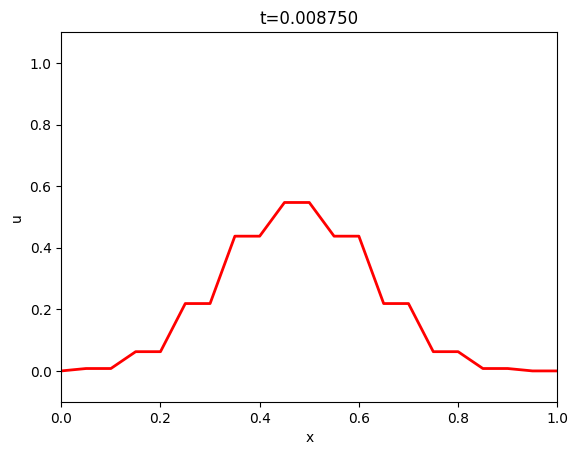

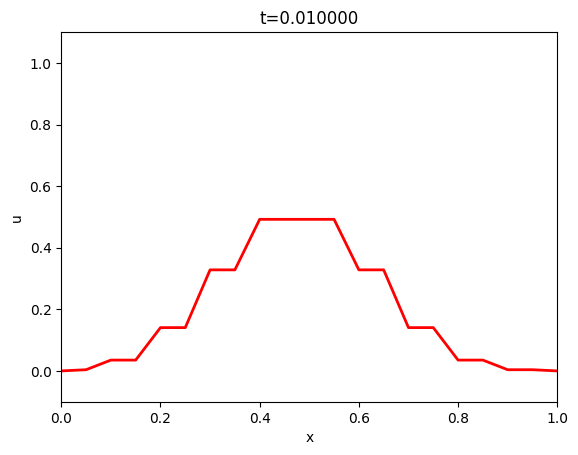

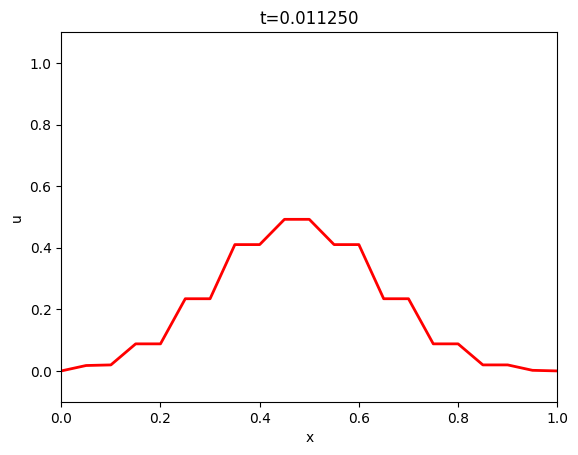

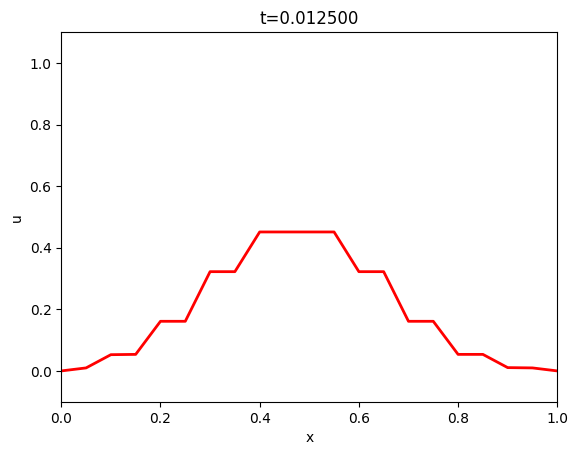

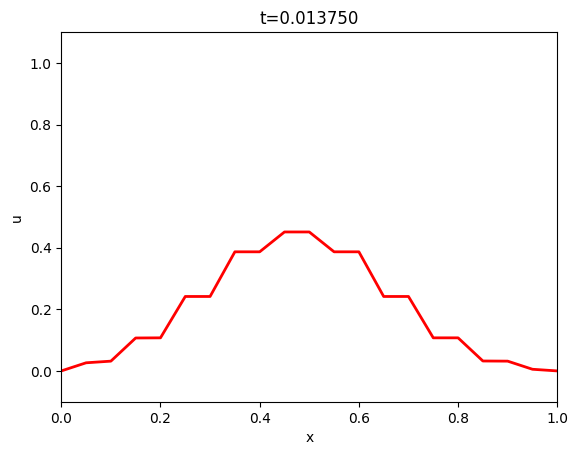

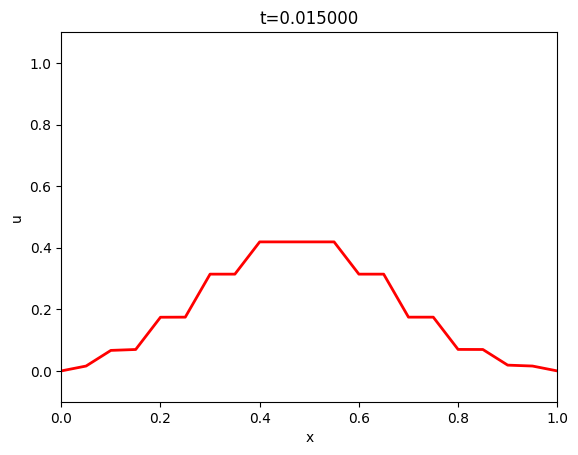

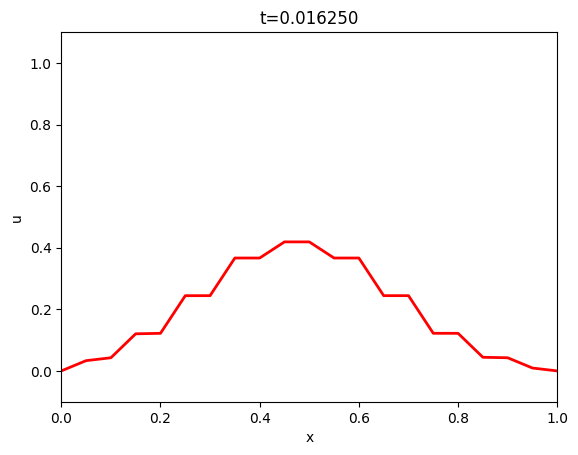

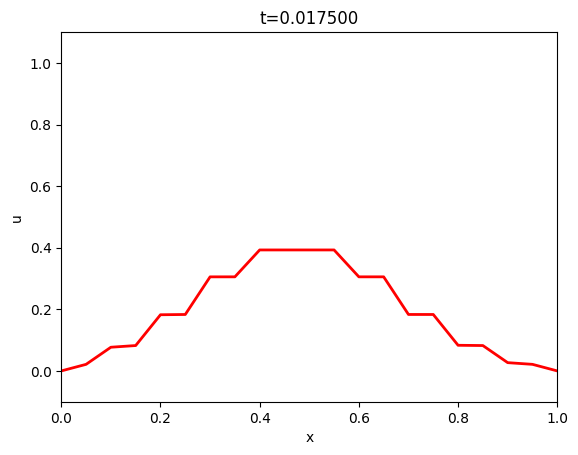

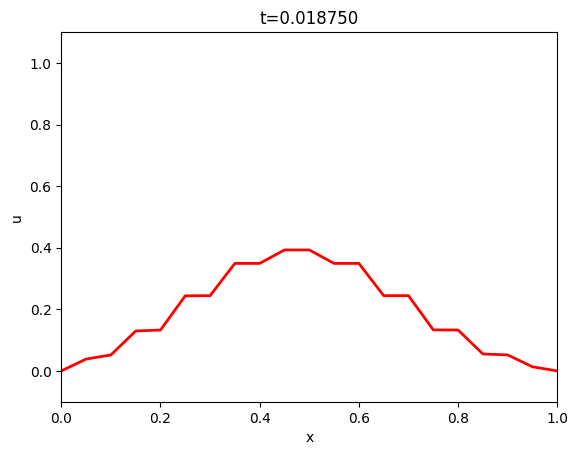

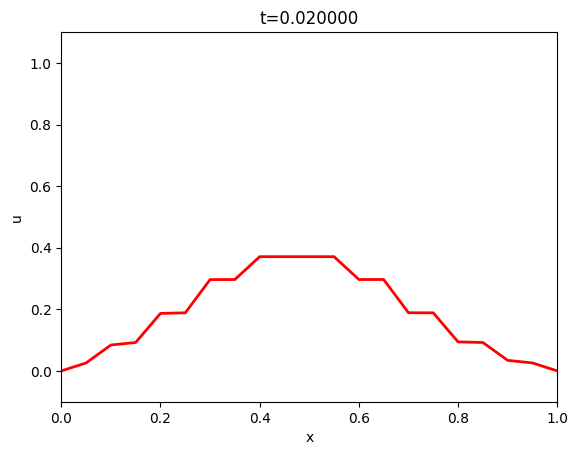

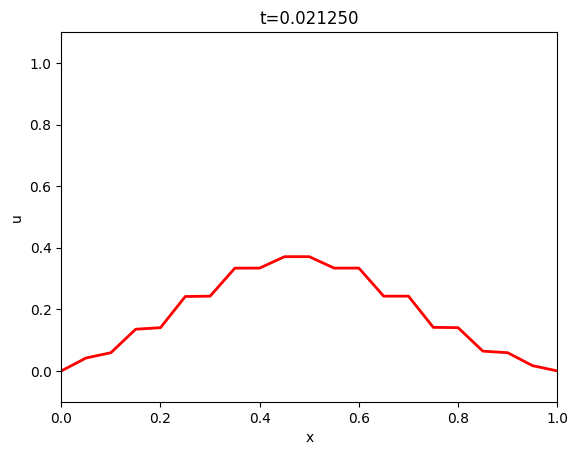

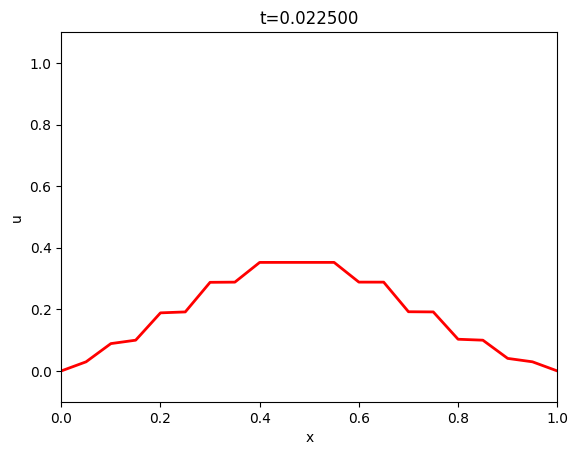

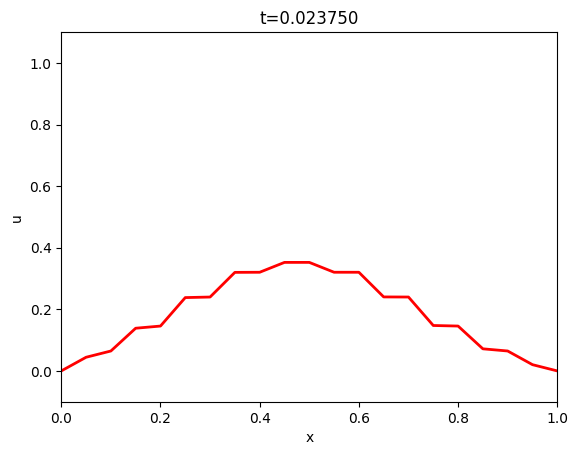

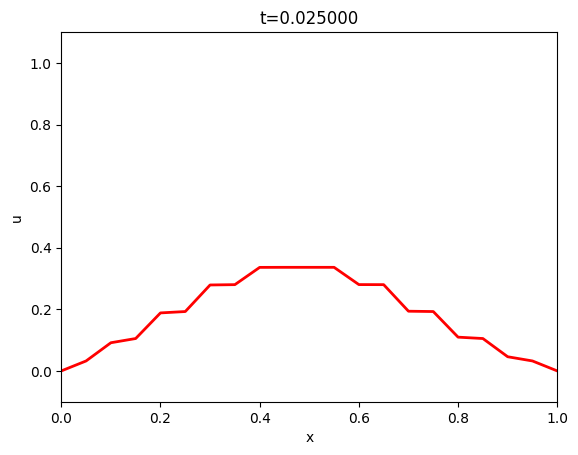

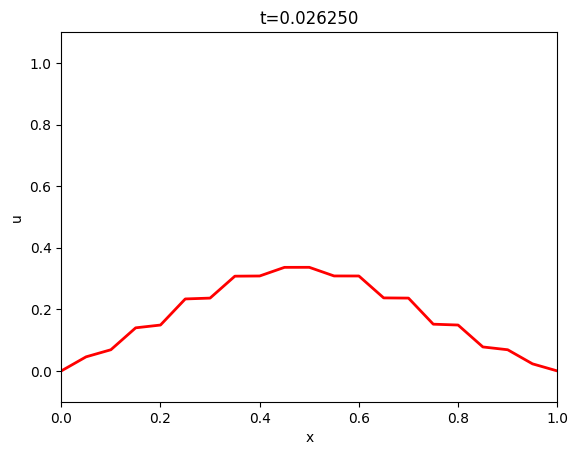

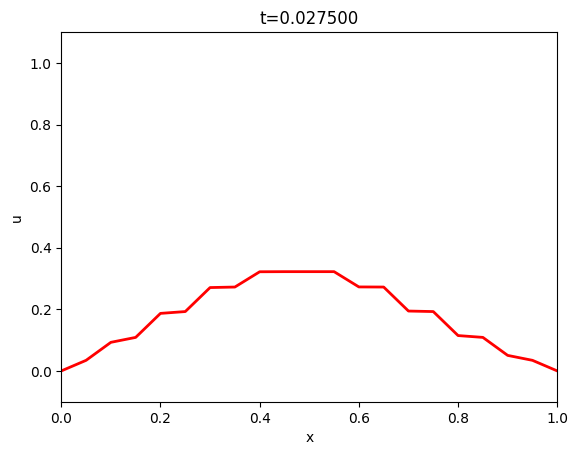

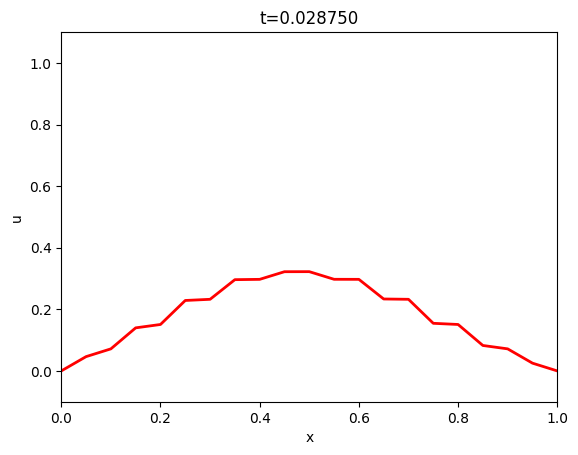

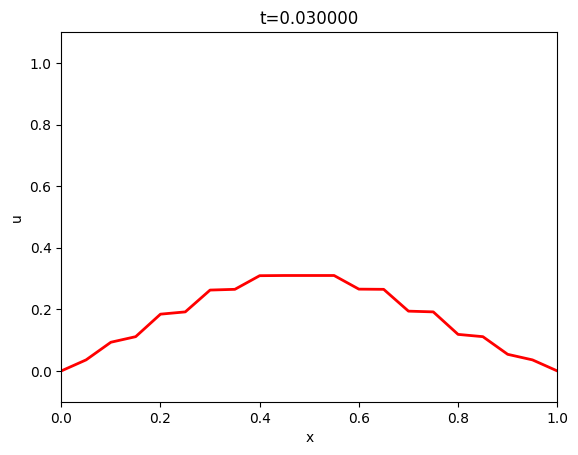

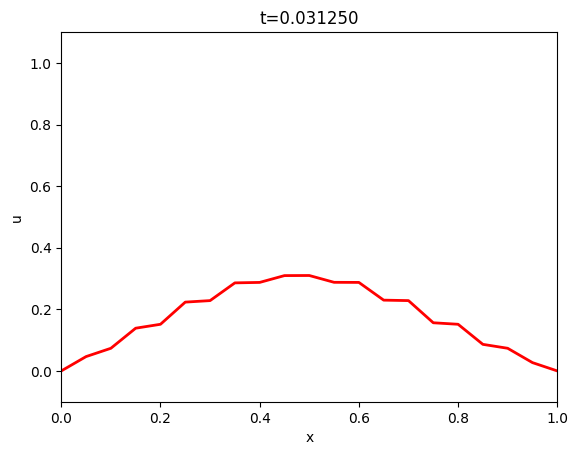

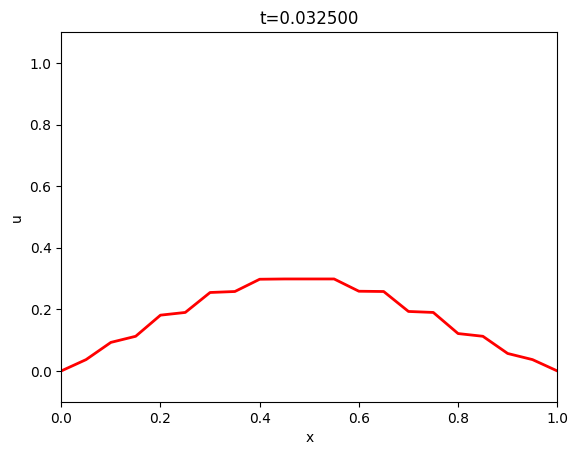

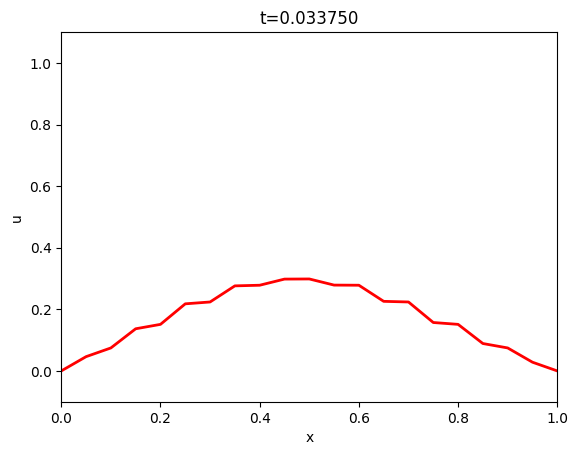

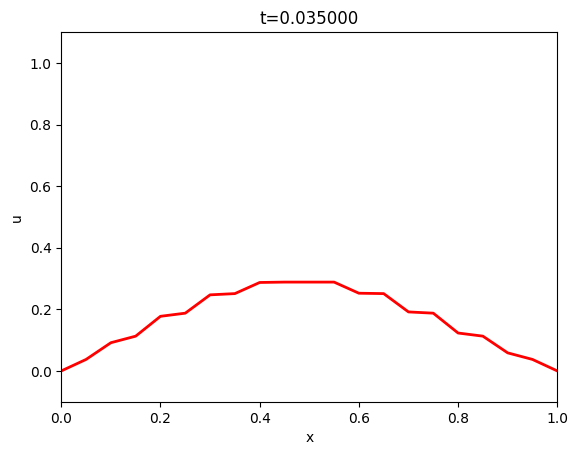

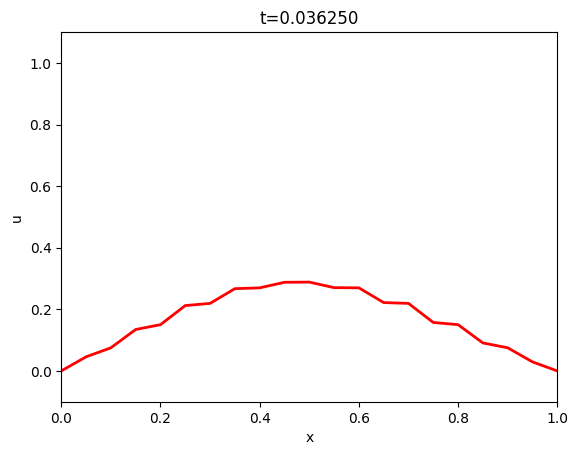

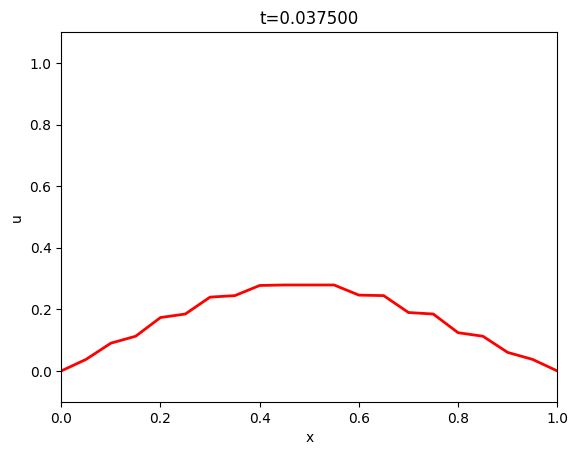

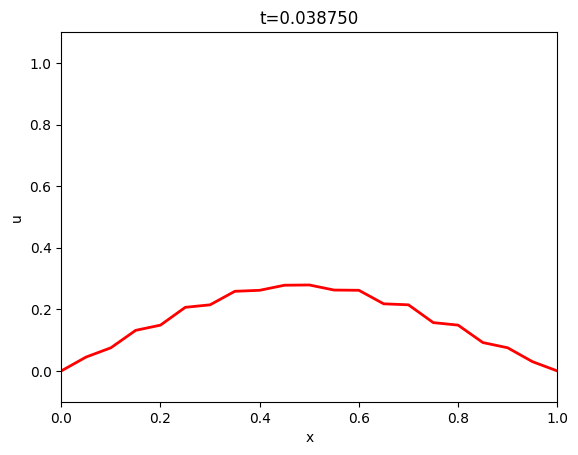

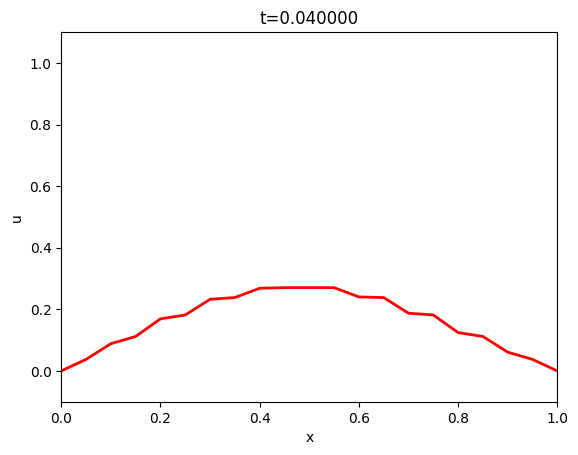

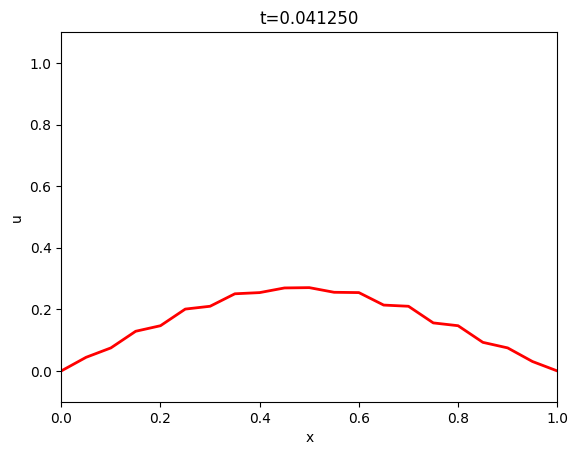

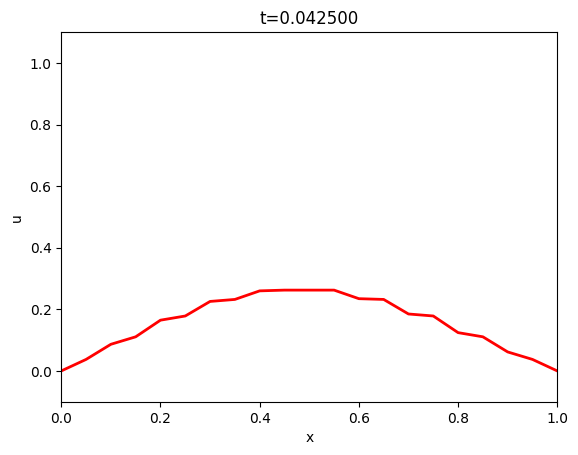

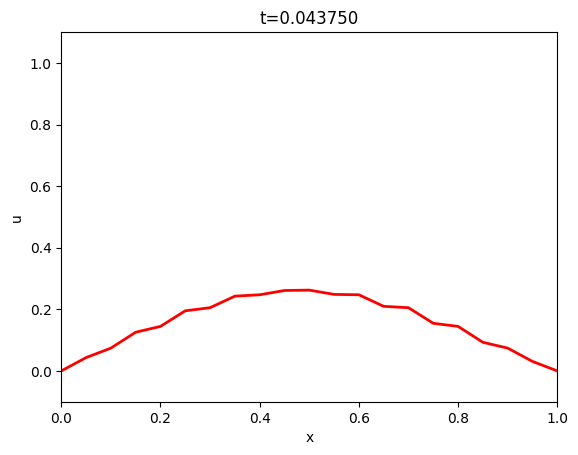

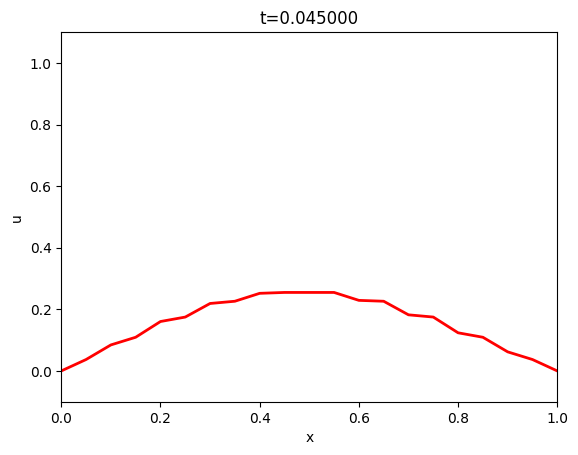

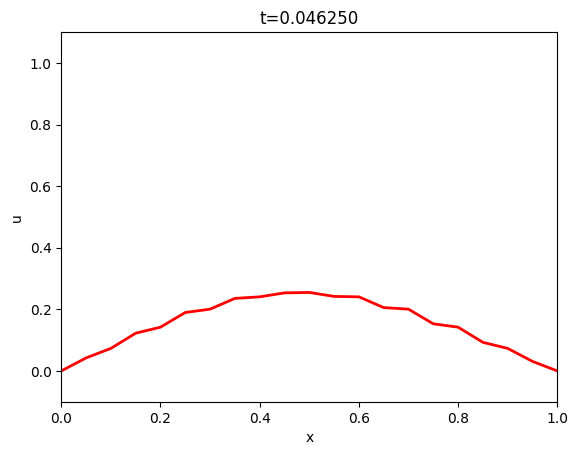

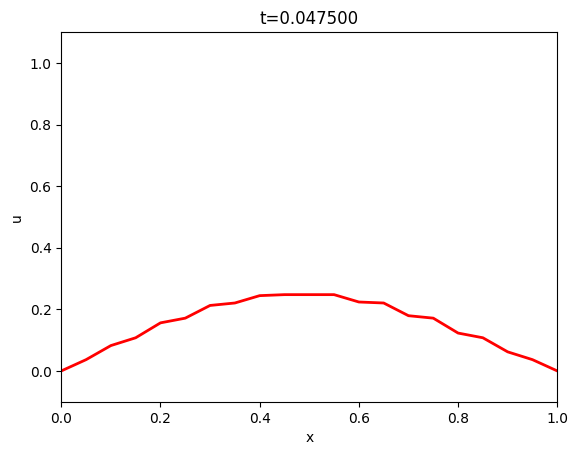

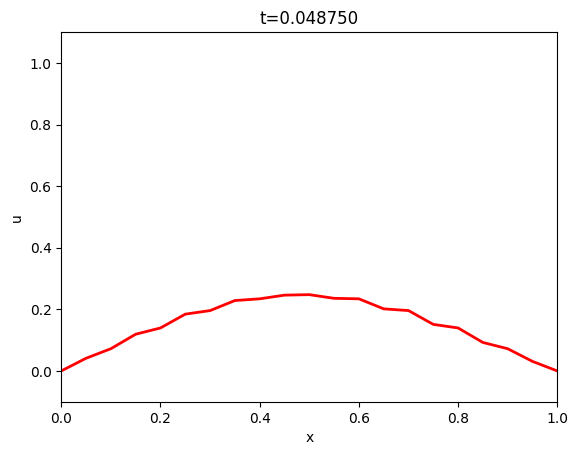

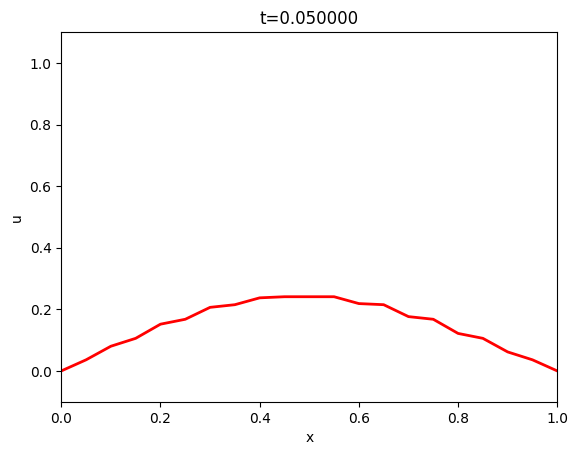

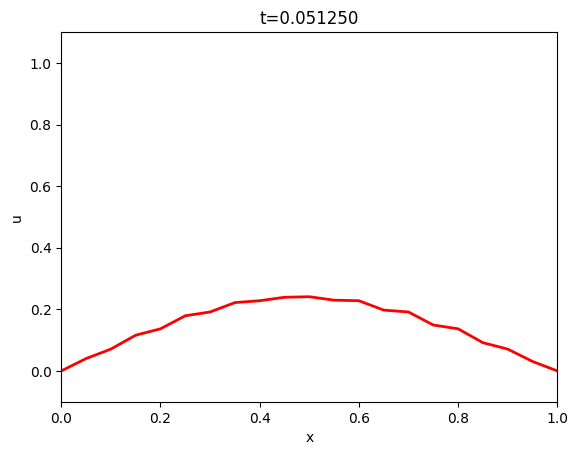

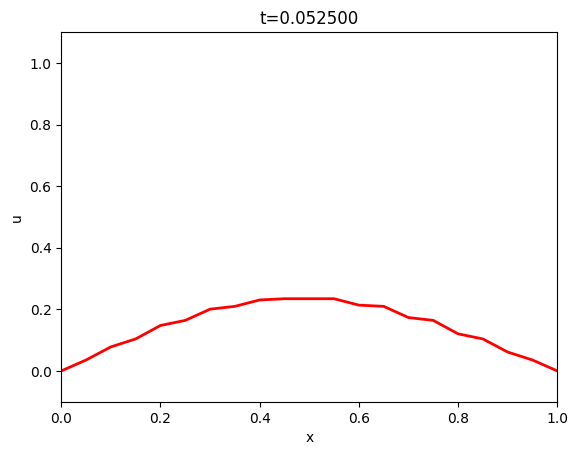

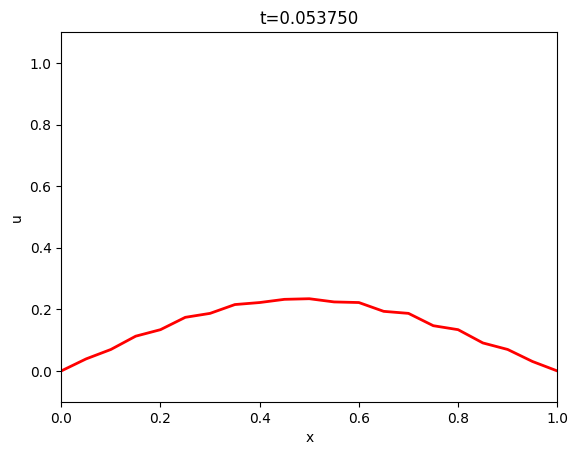

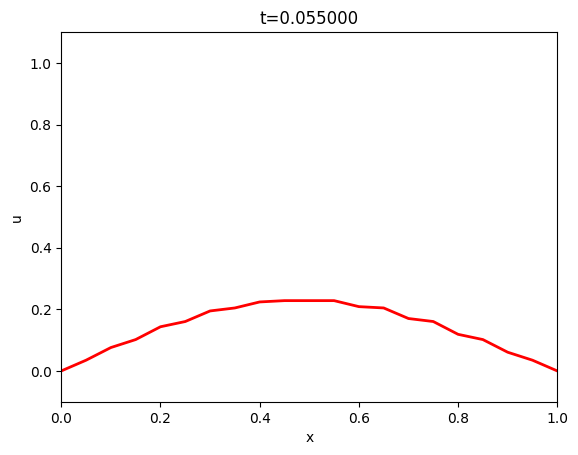

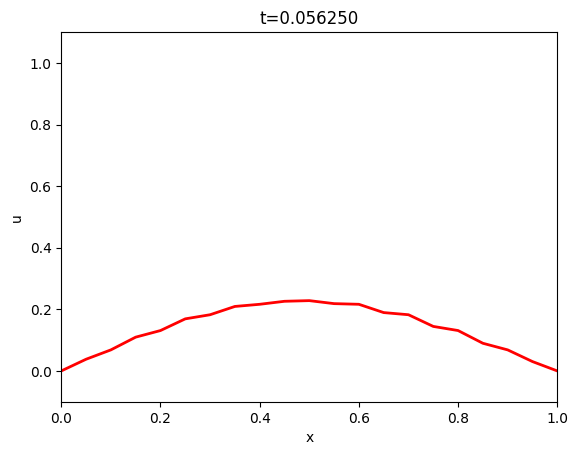

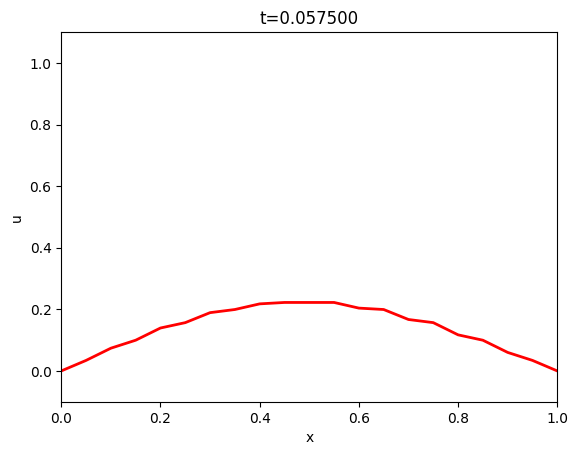

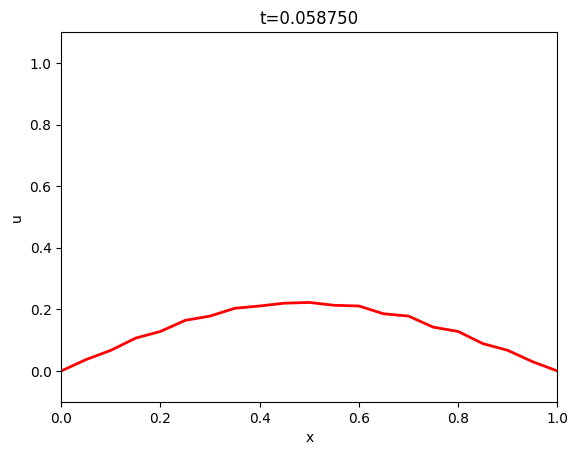

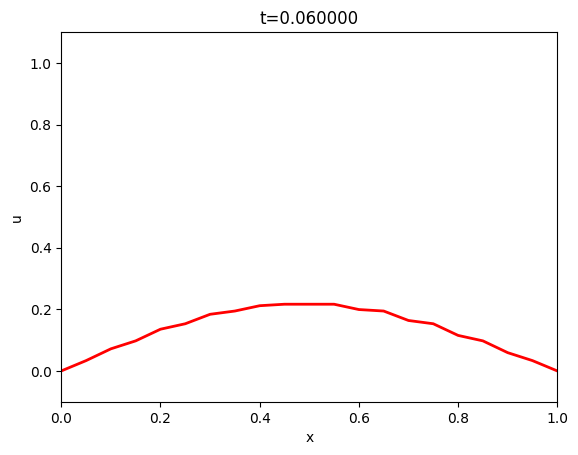

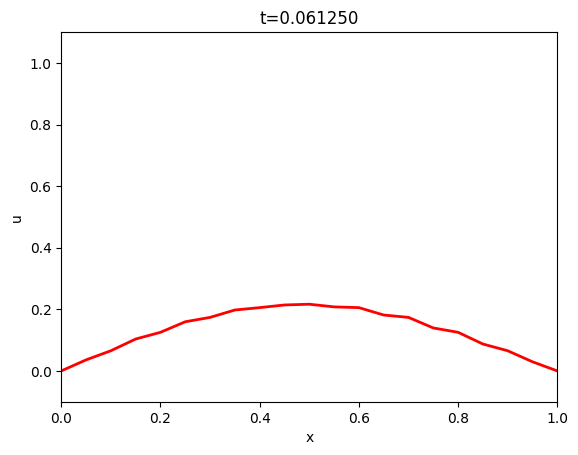

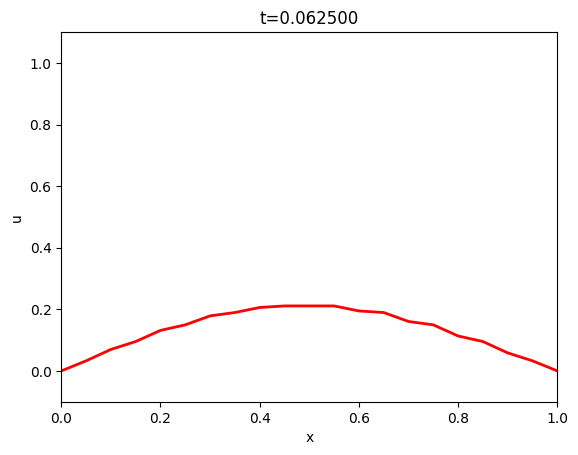

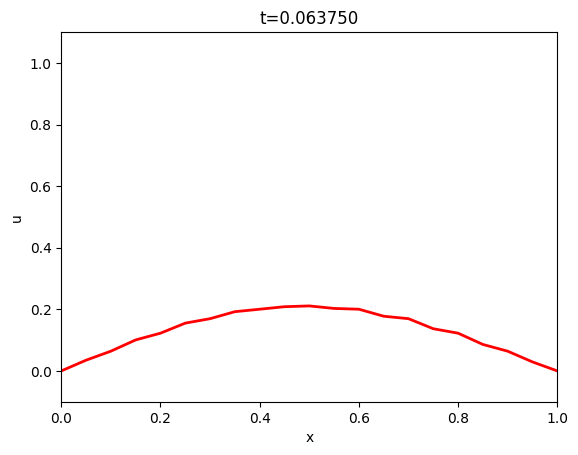

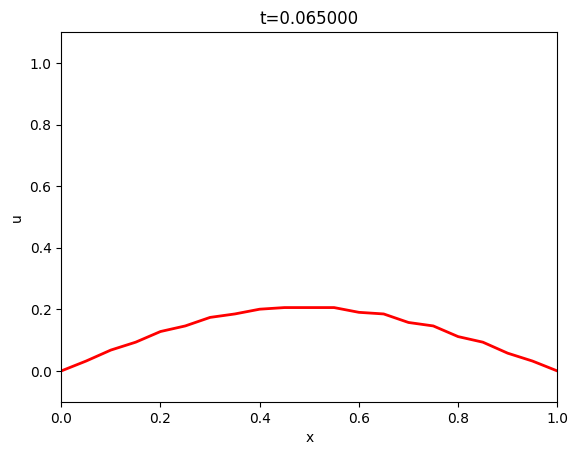

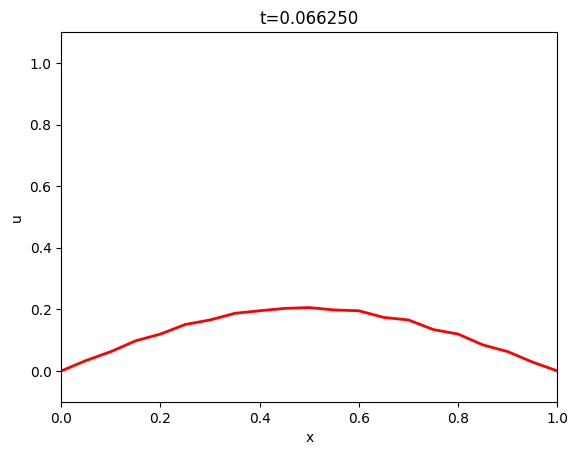

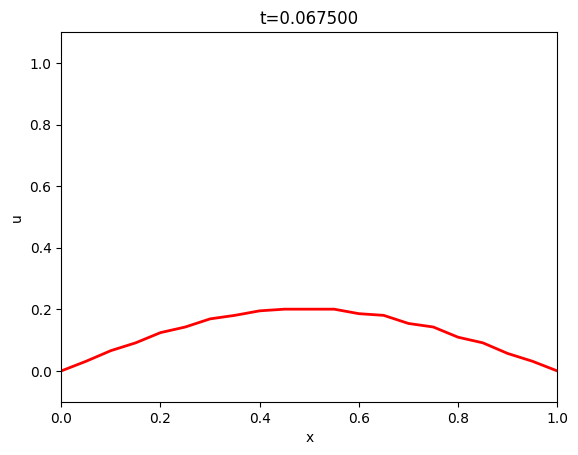

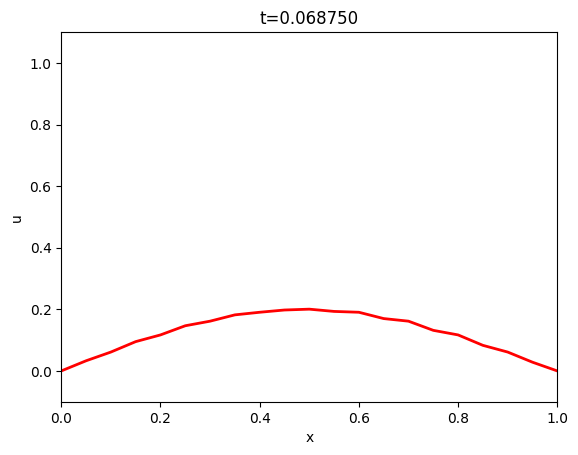

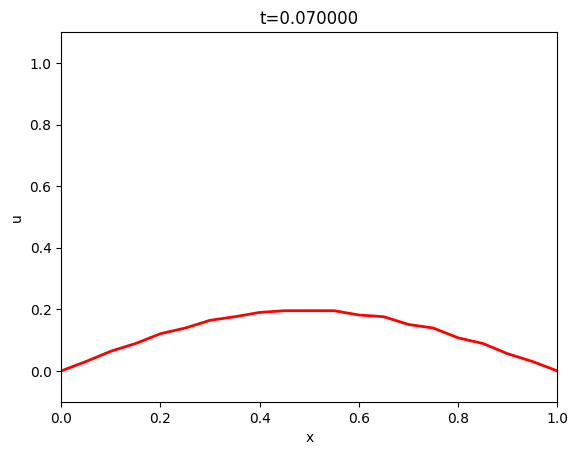

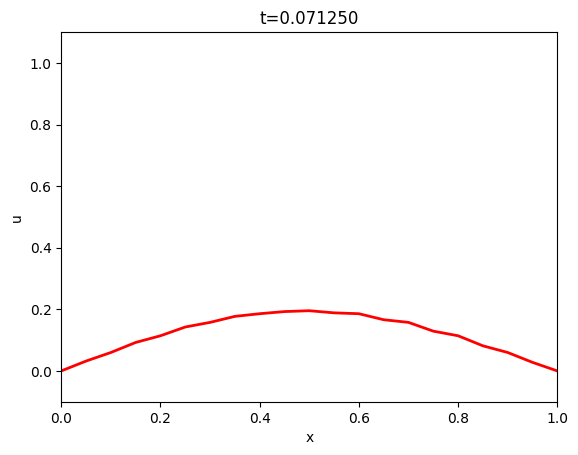

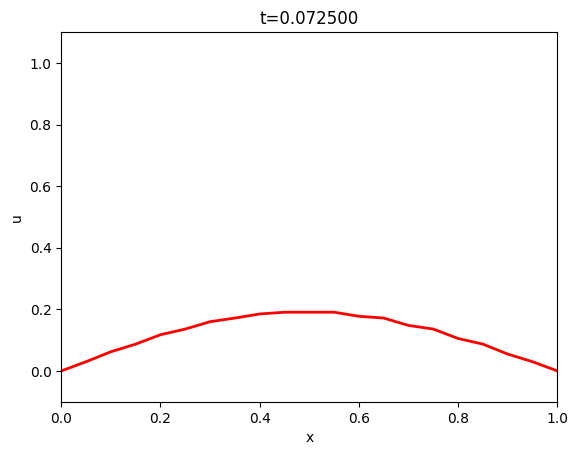

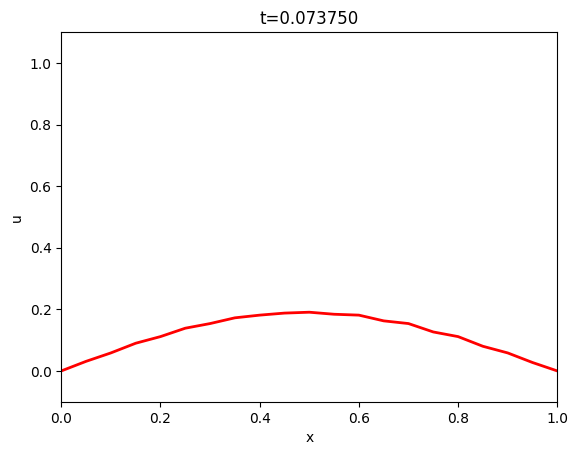

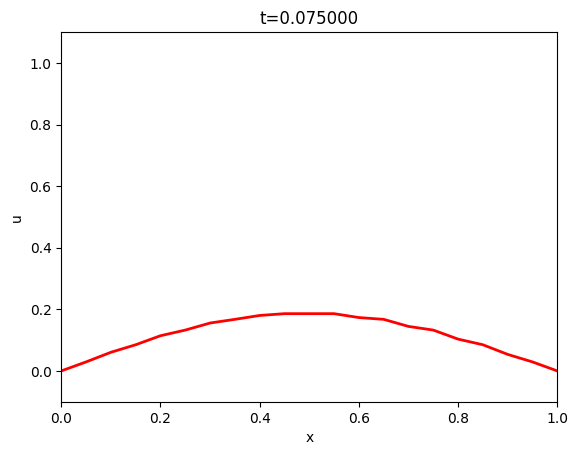

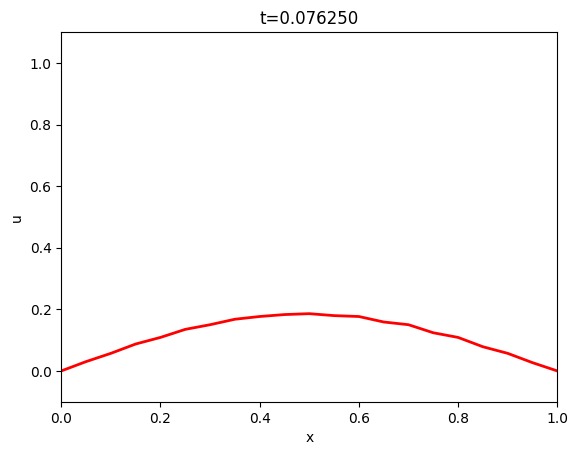

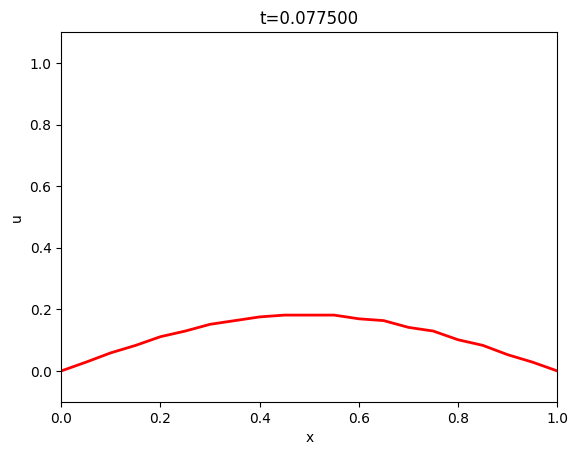

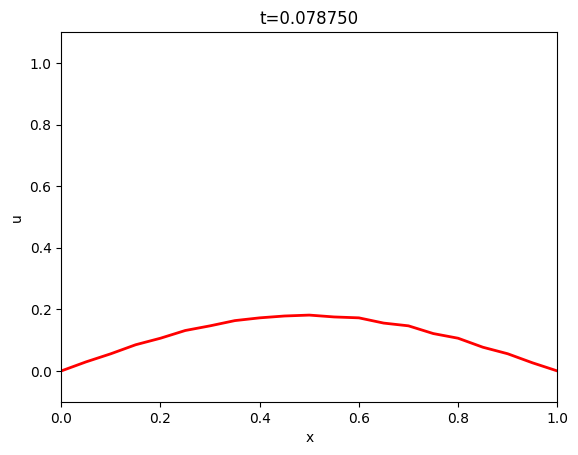

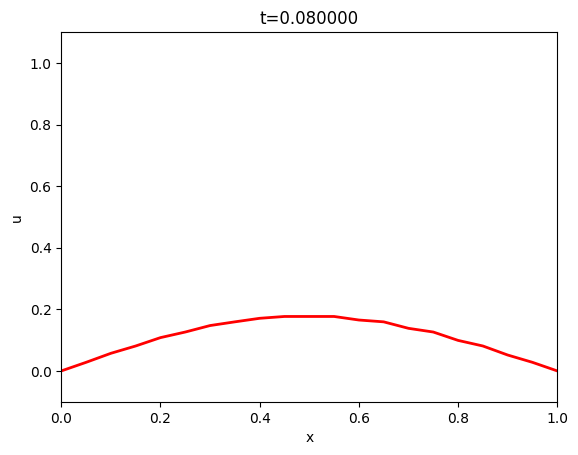

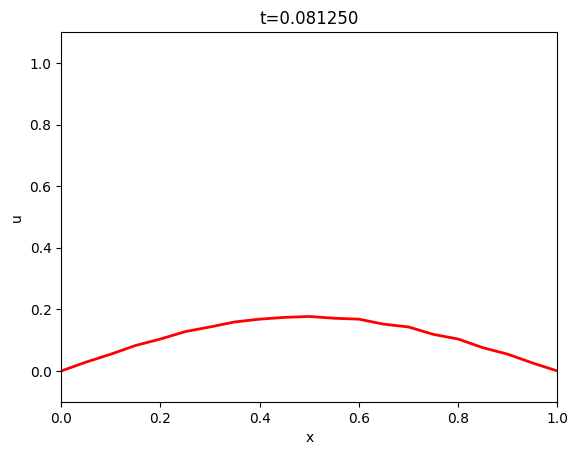

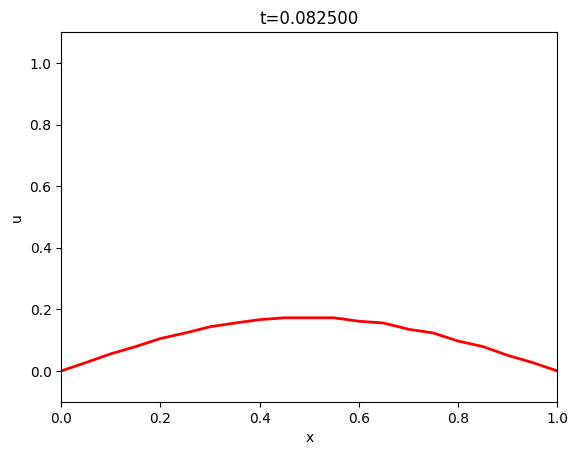

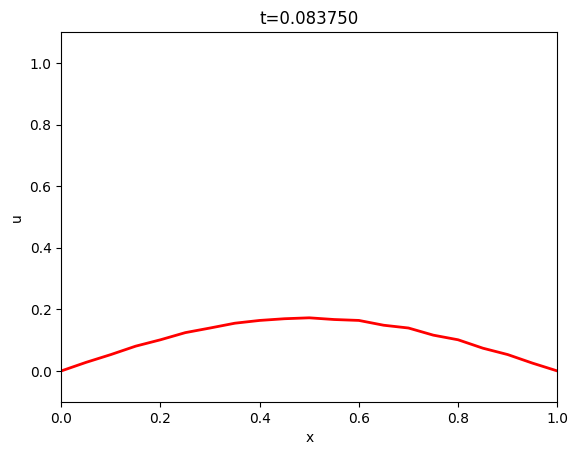

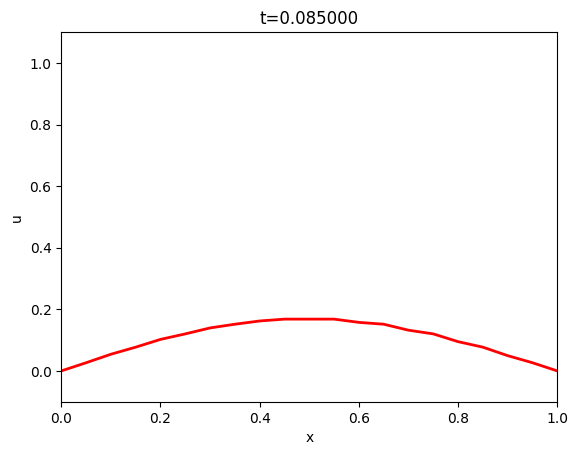

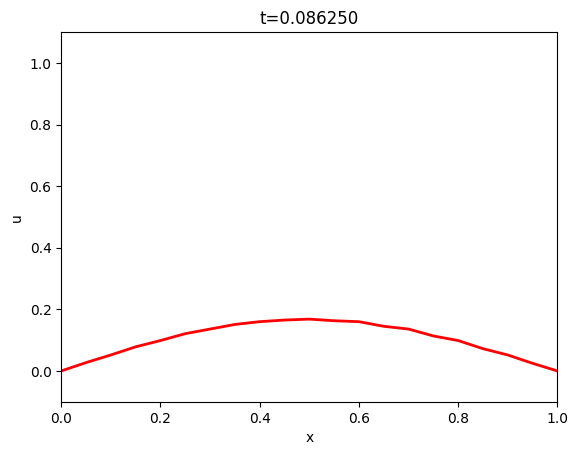

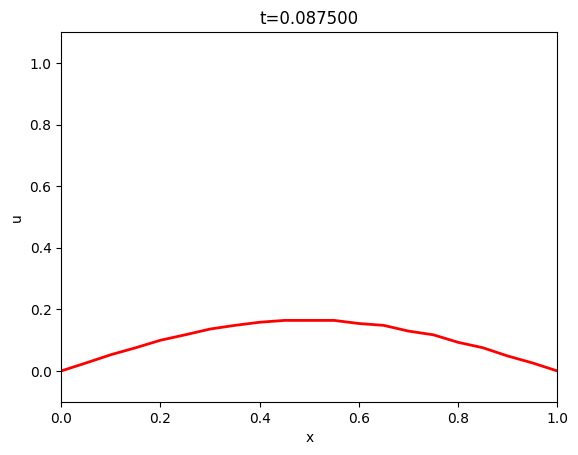

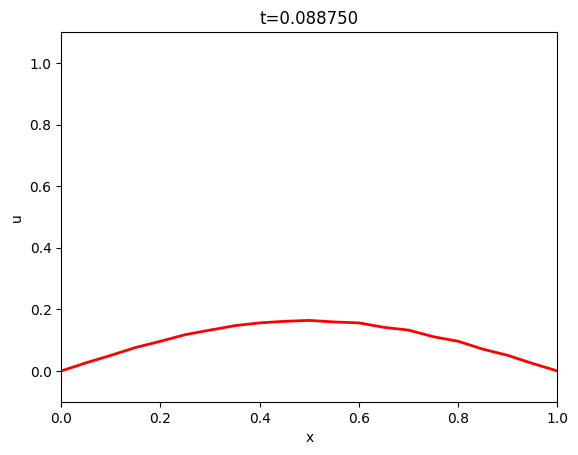

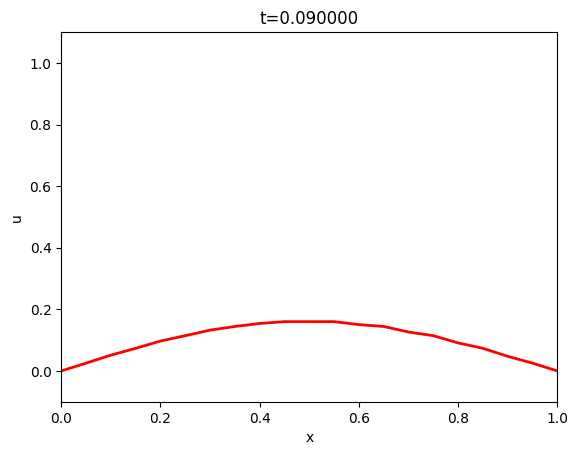

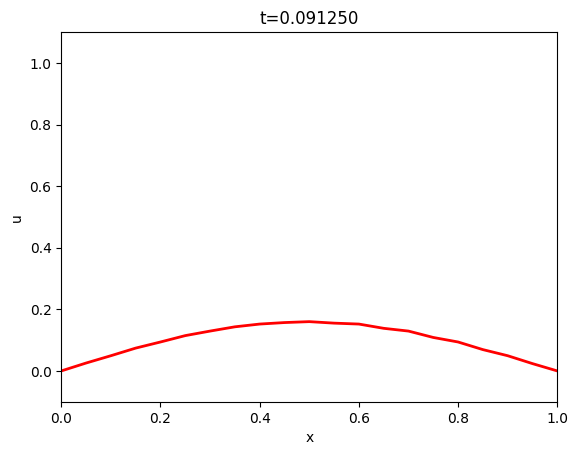

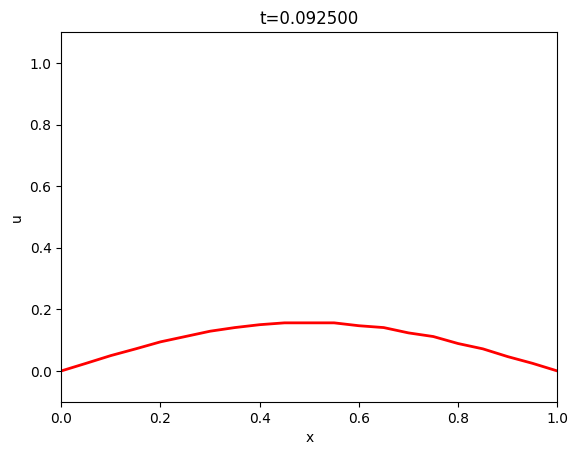

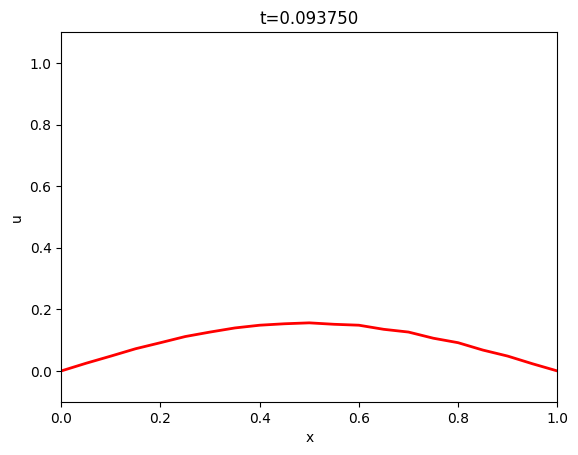

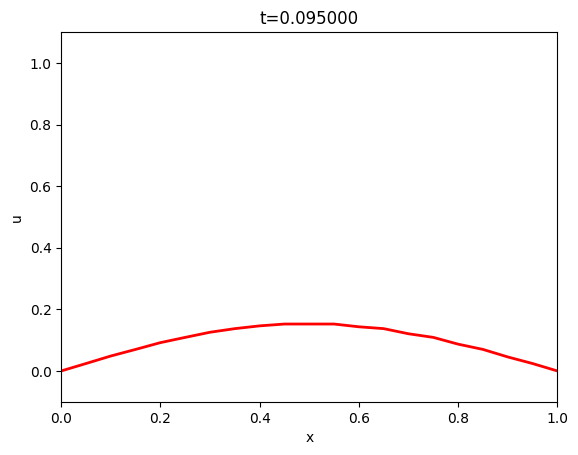

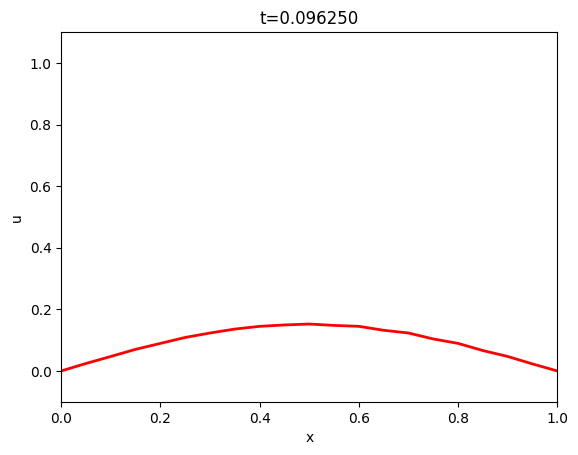

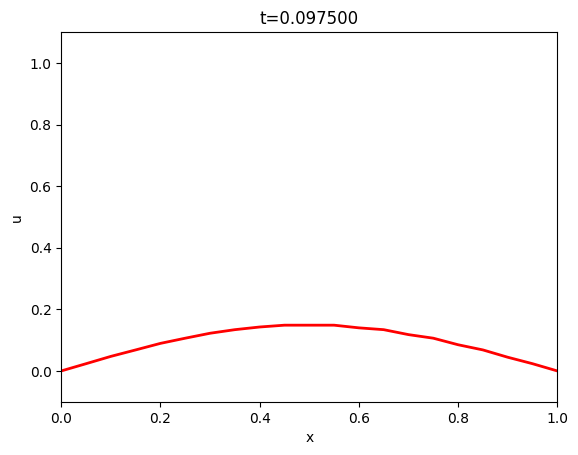

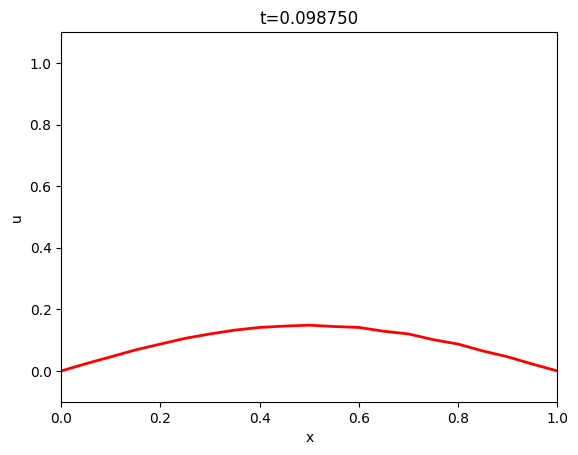

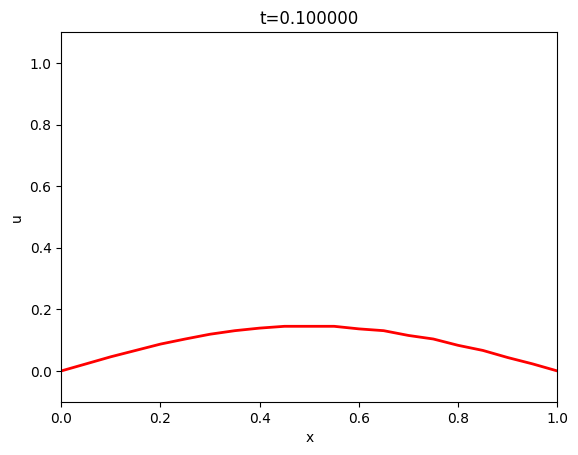

CPU time for plug input: 39.77931042700004
PDF saved to 'output_plots_plug.pdf'
**************************
For Gaussian input:


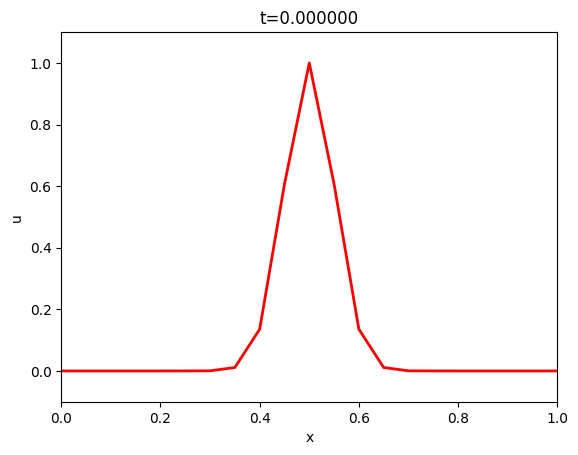

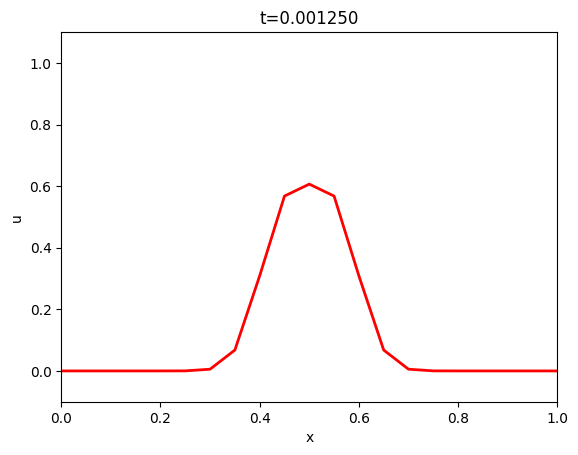

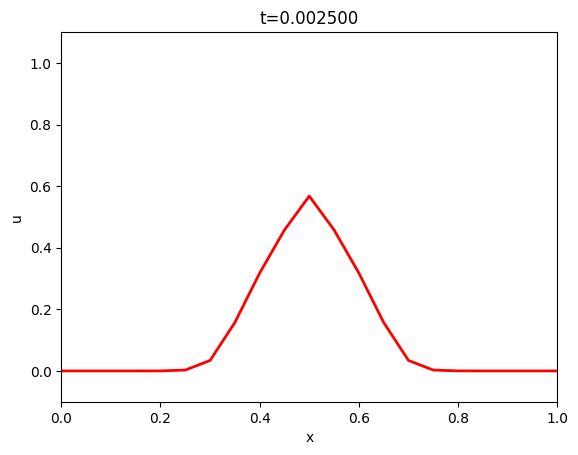

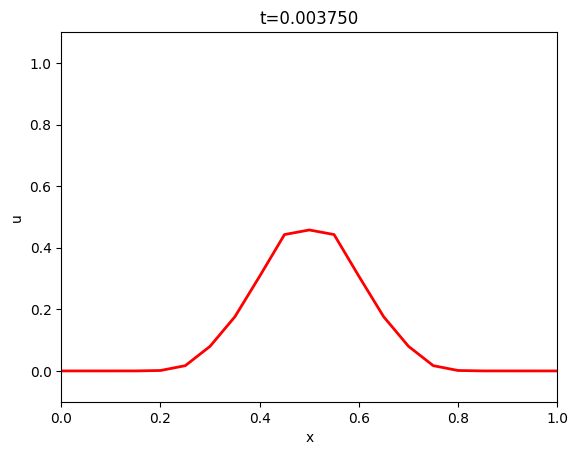

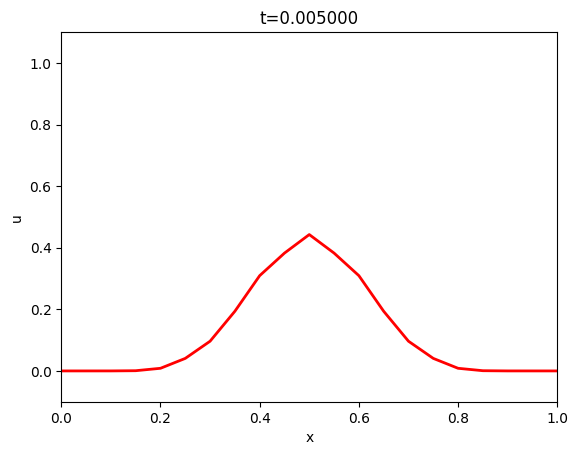

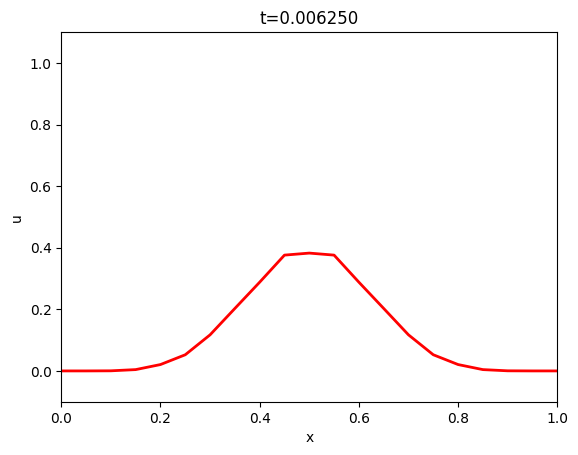

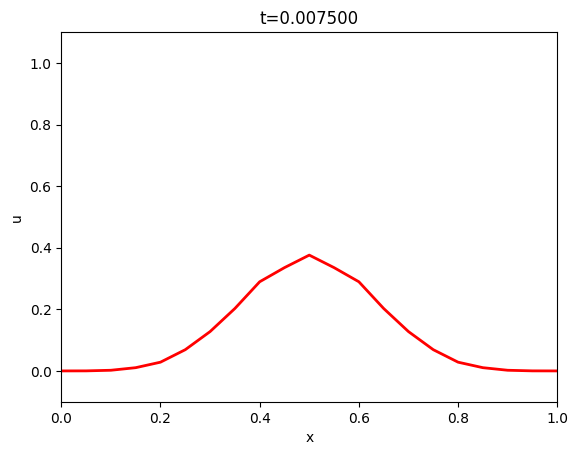

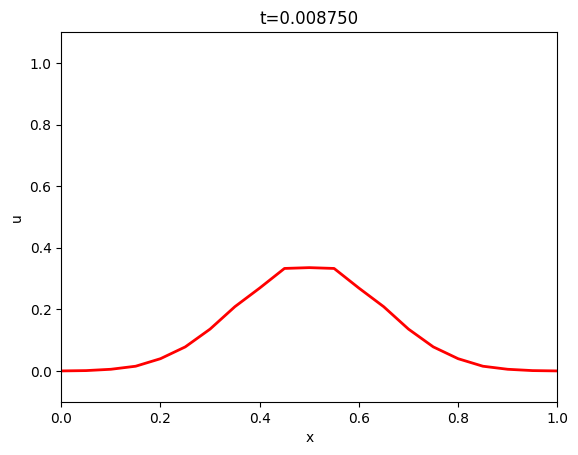

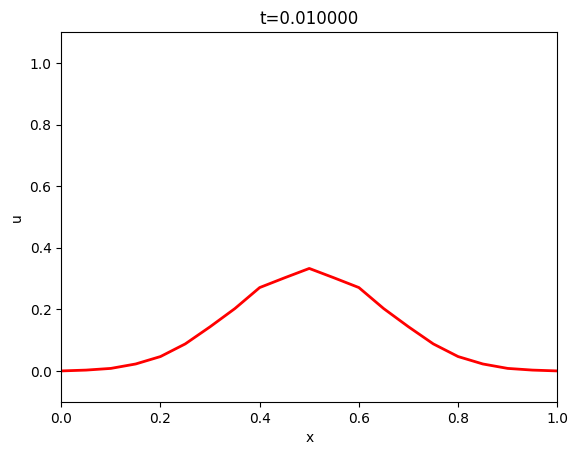

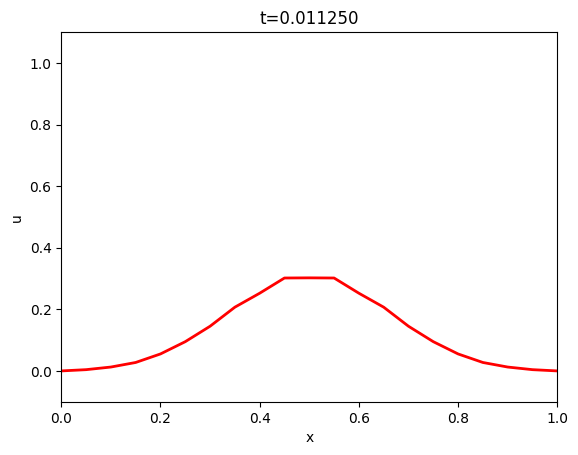

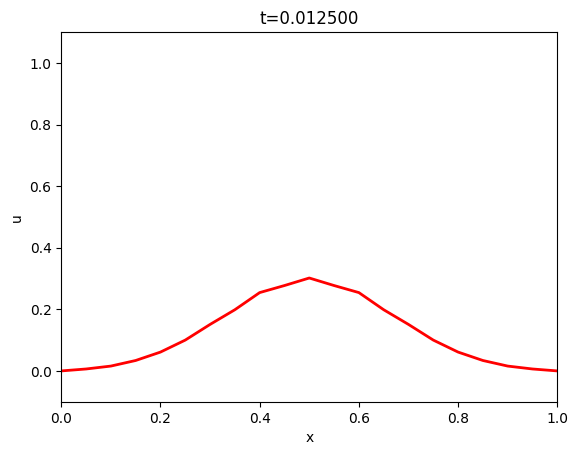

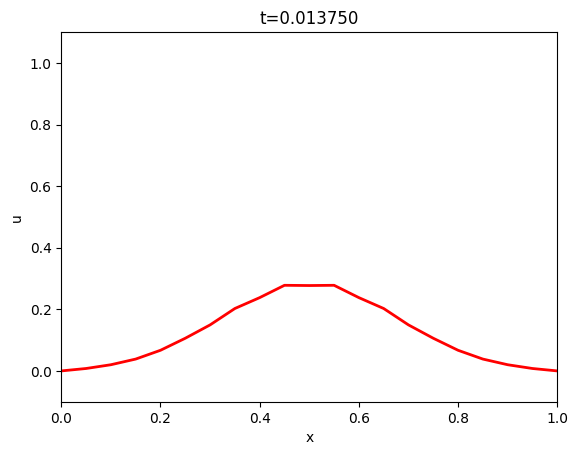

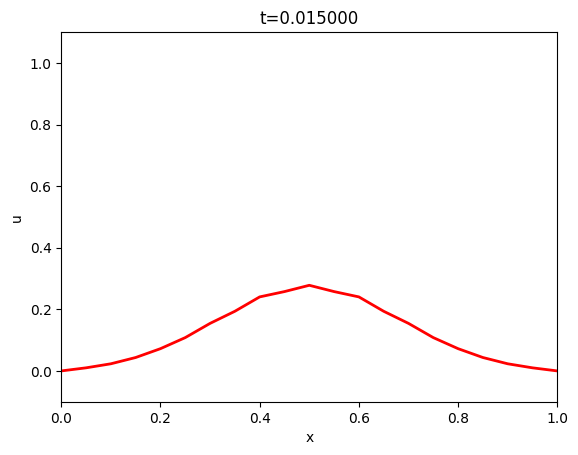

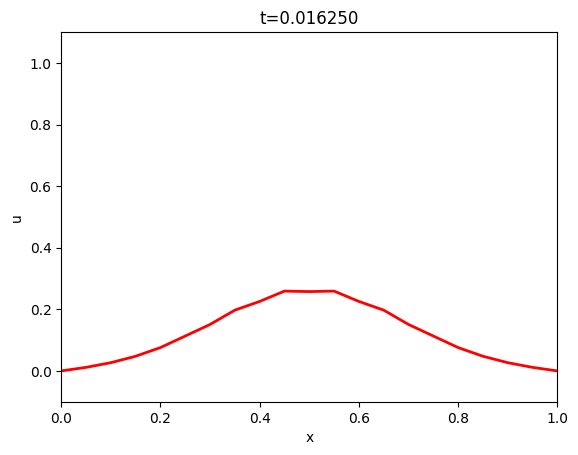

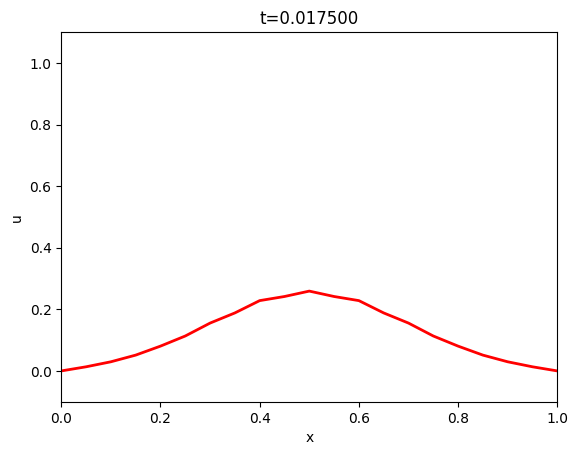

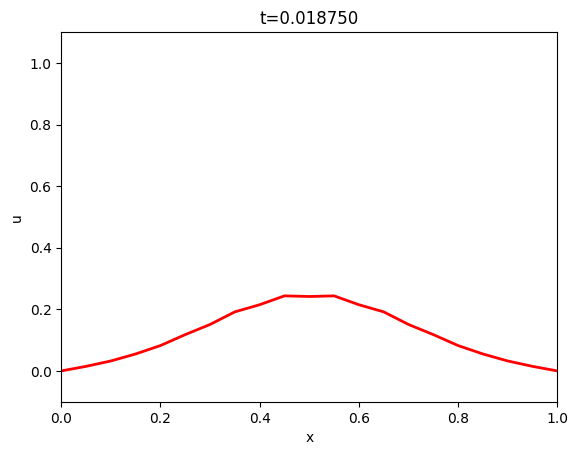

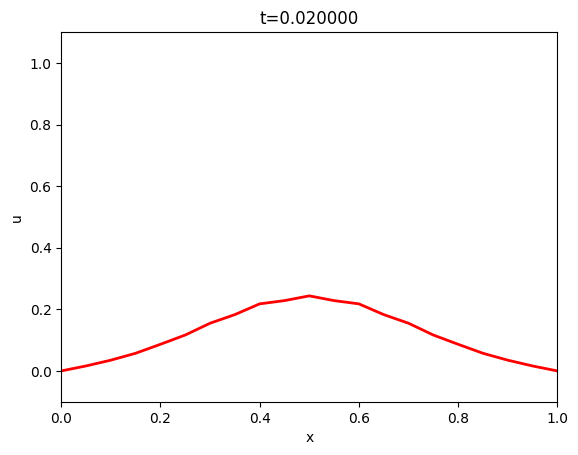

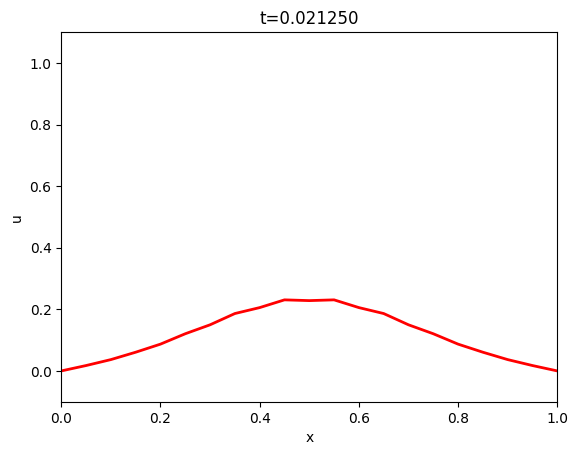

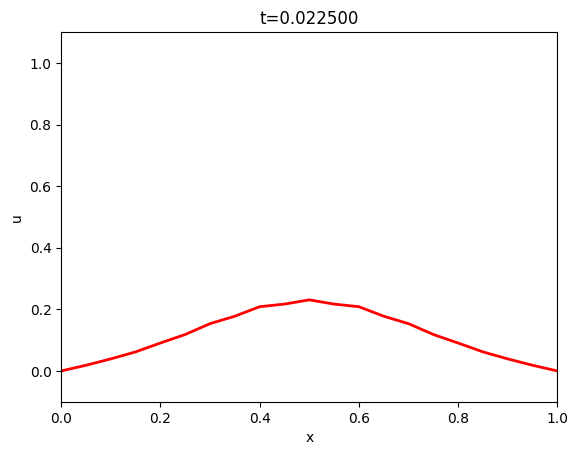

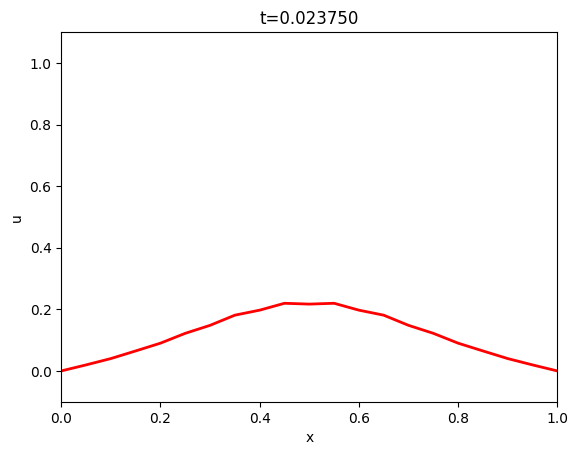

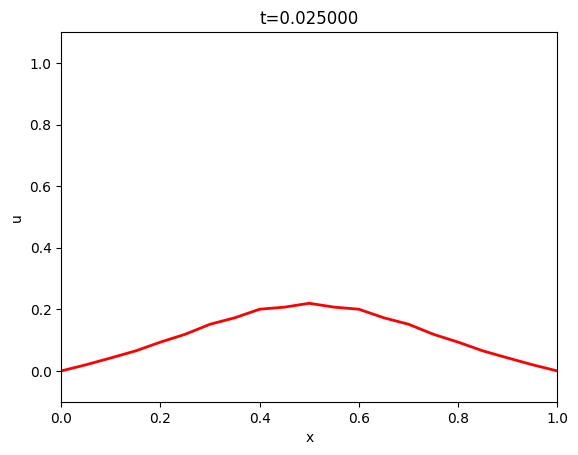

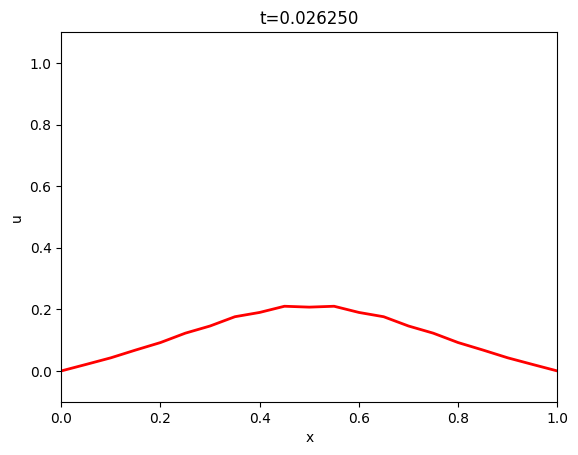

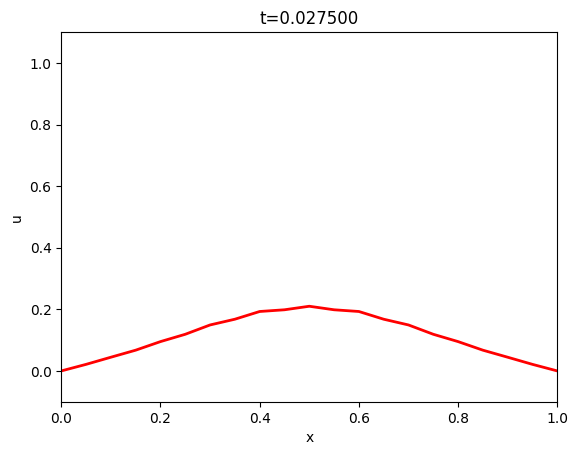

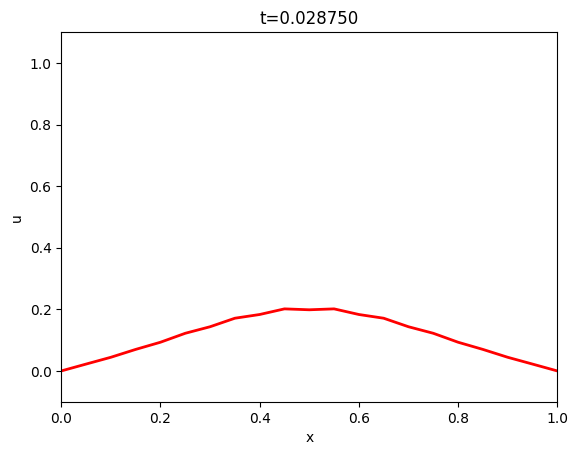

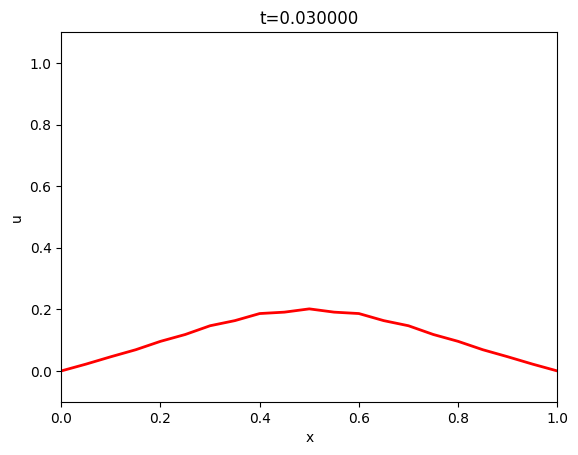

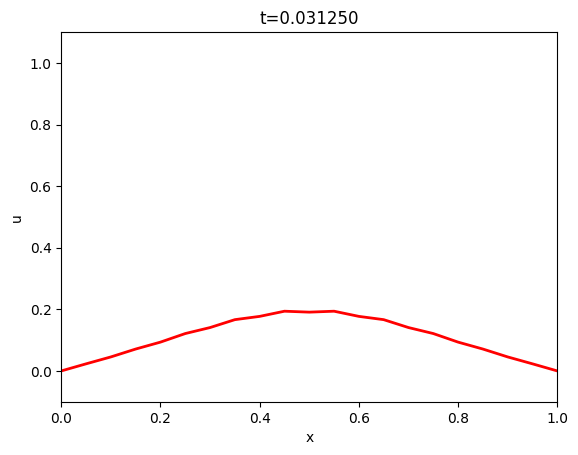

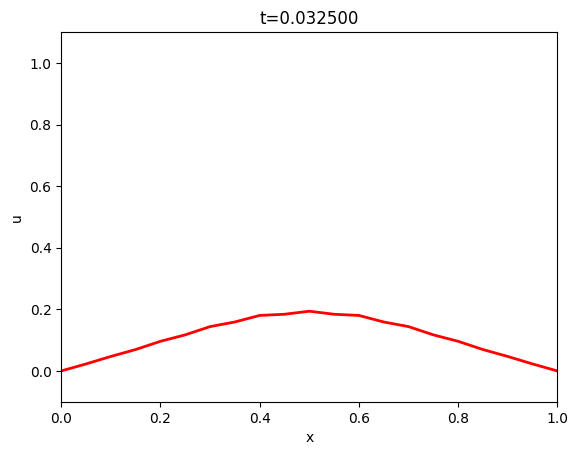

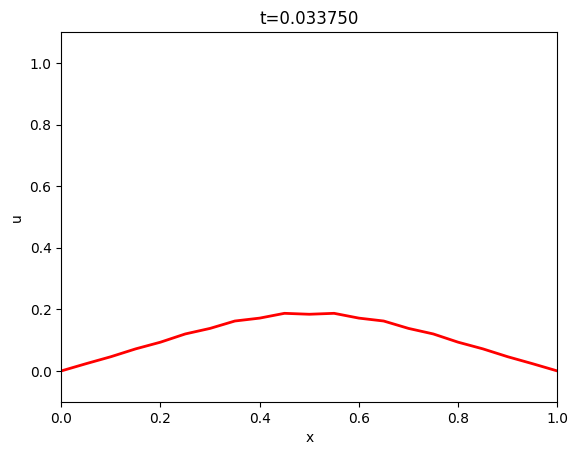

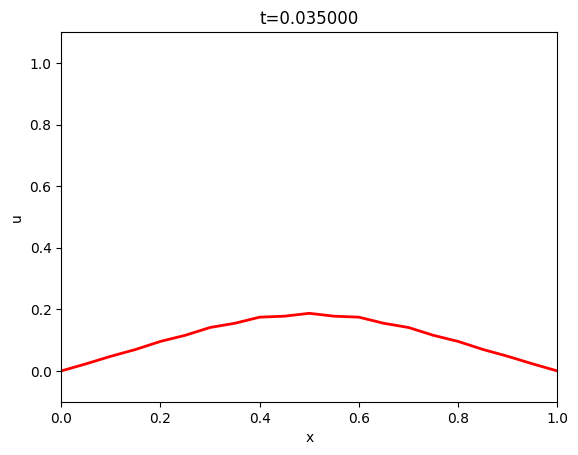

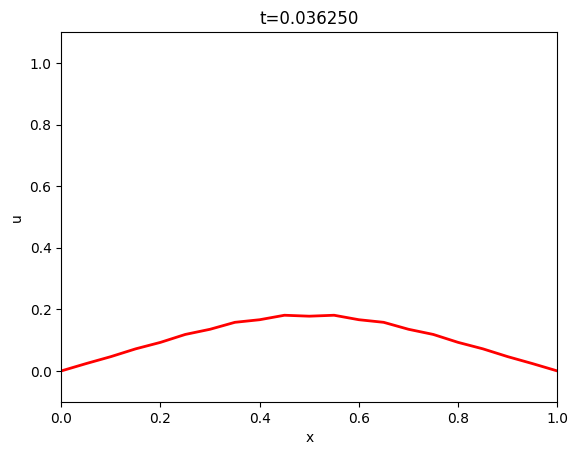

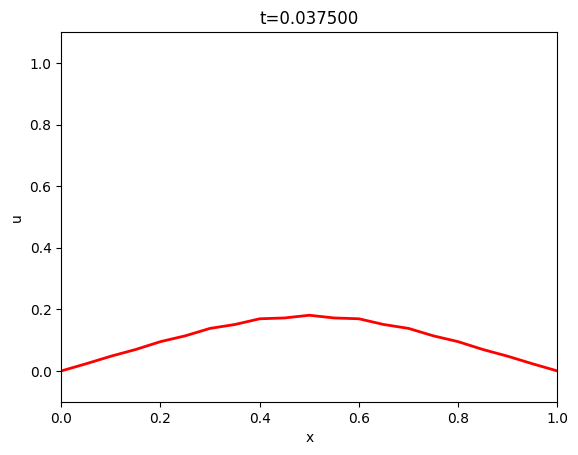

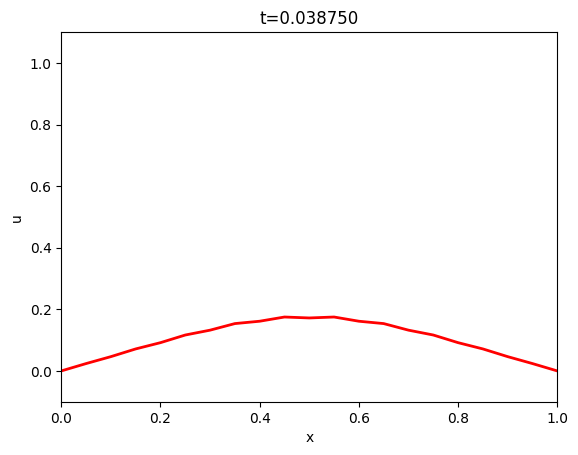

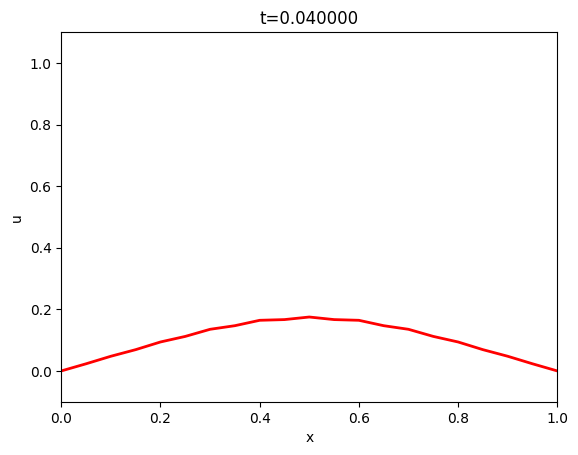

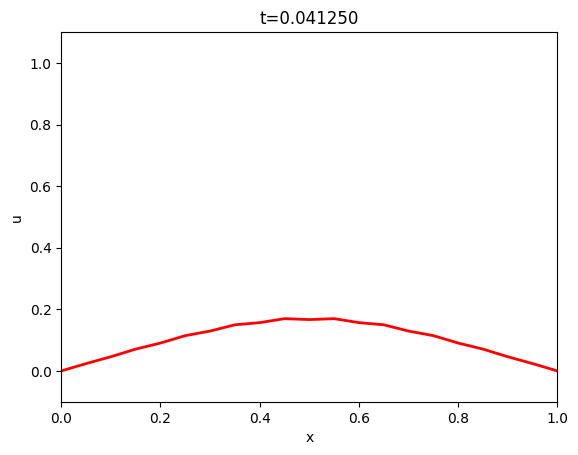

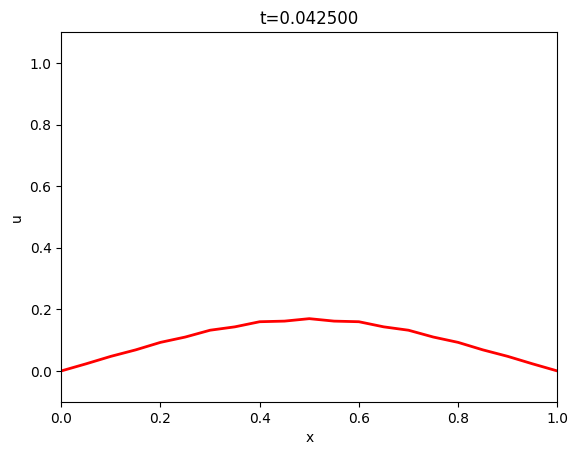

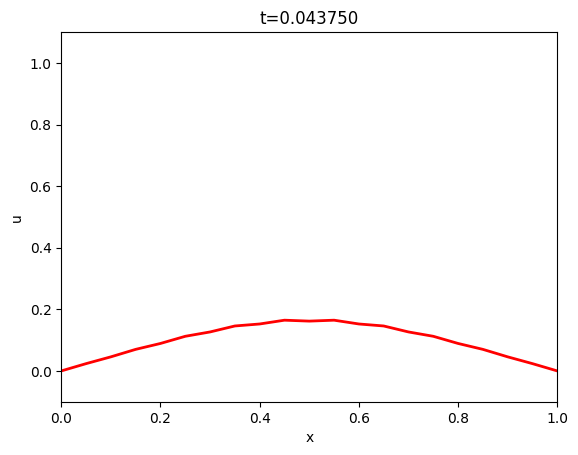

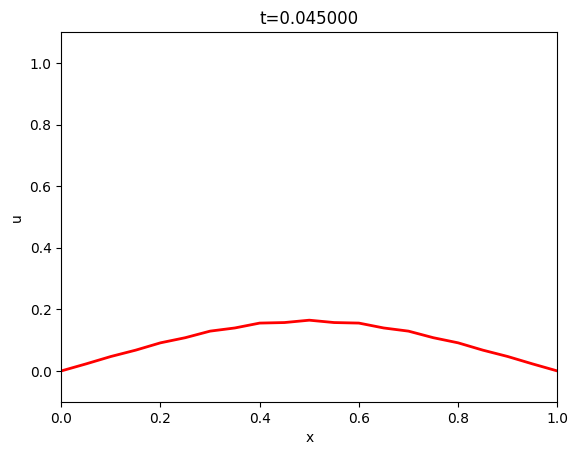

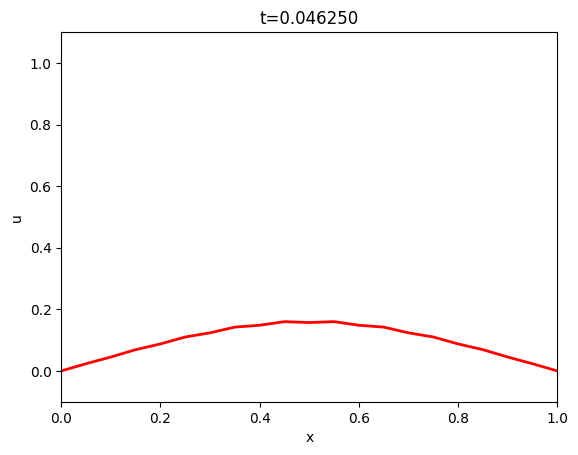

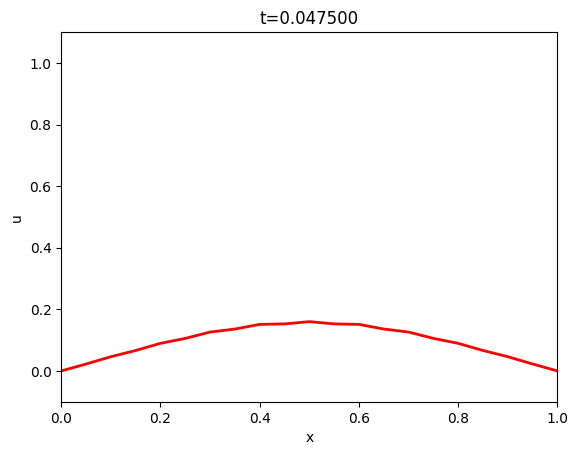

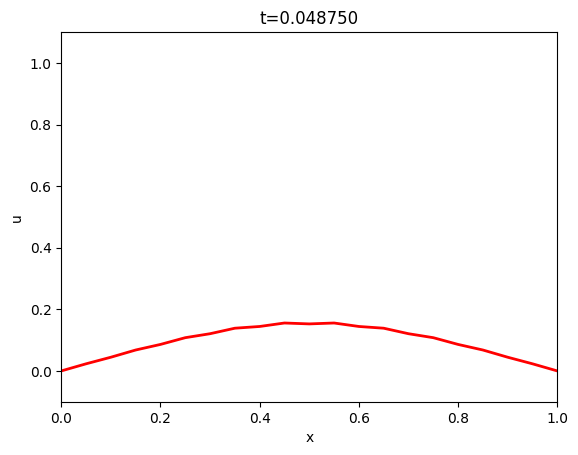

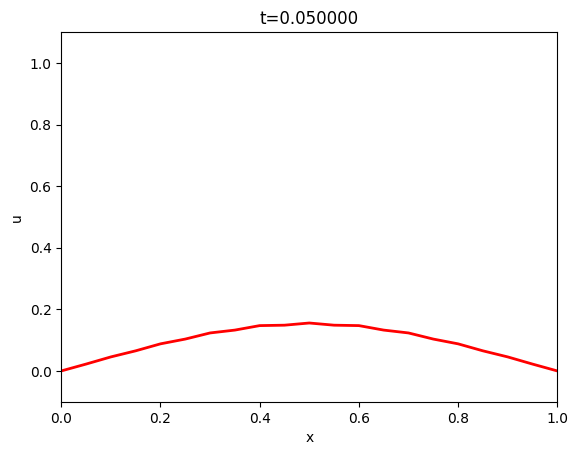

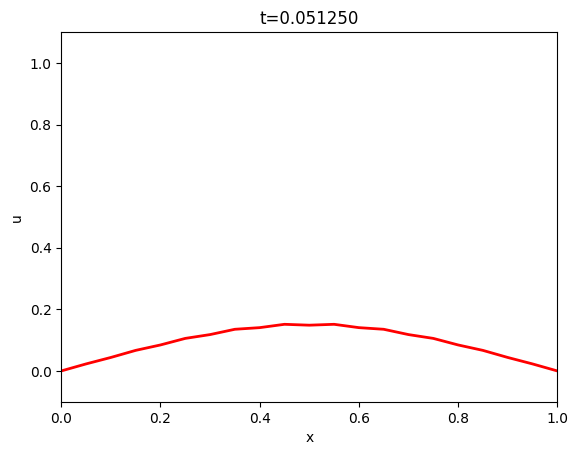

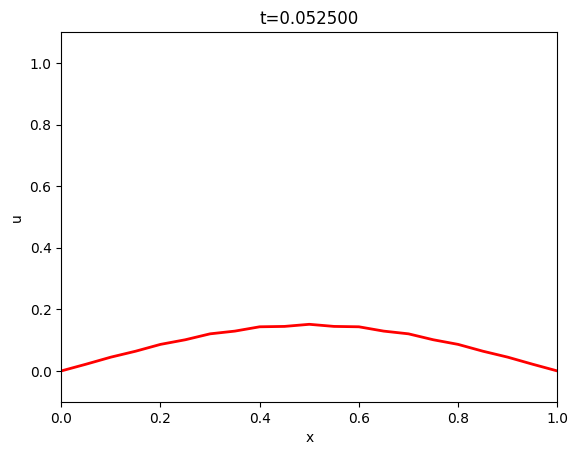

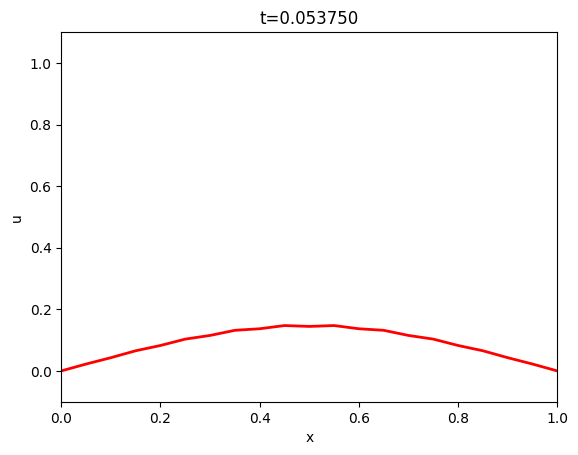

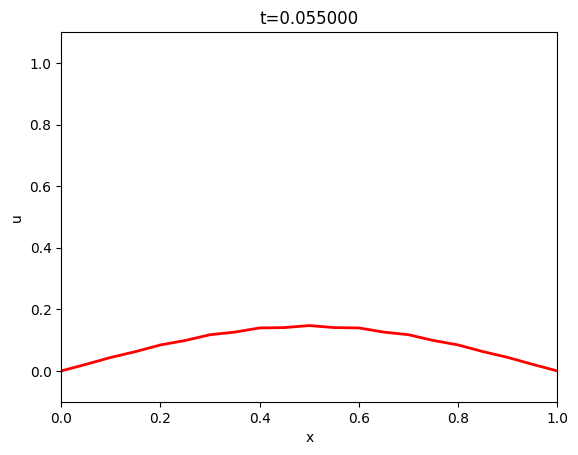

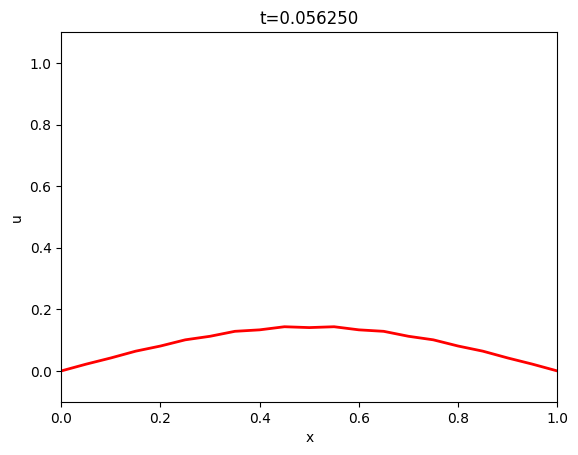

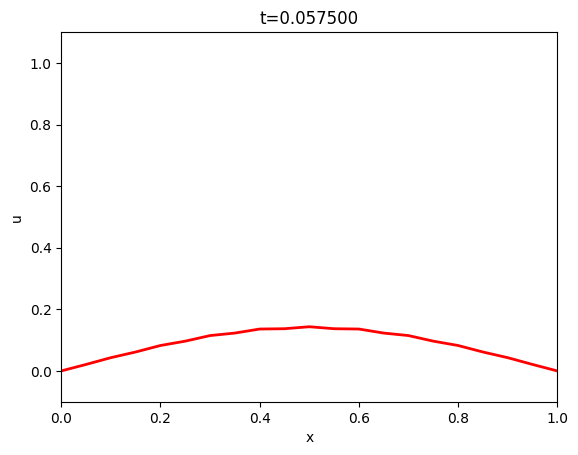

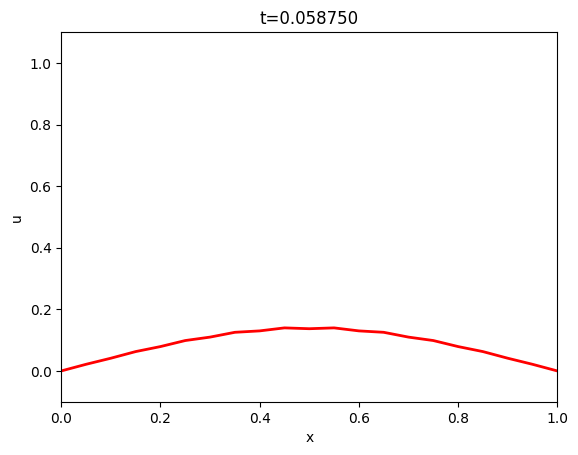

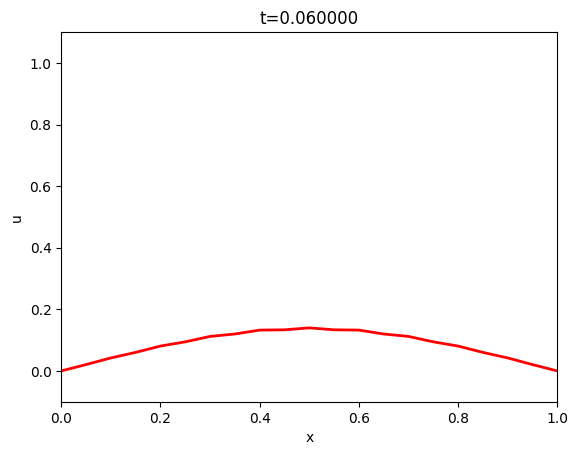

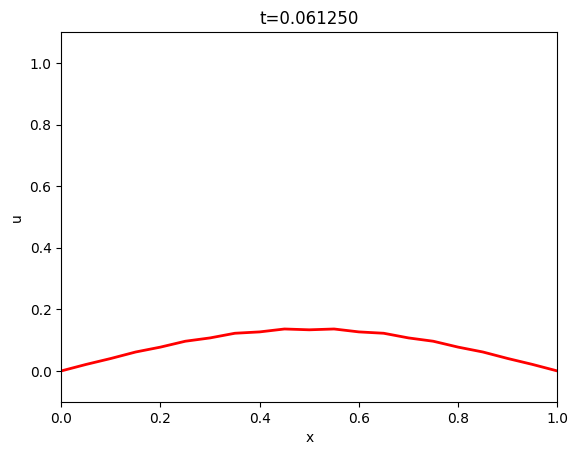

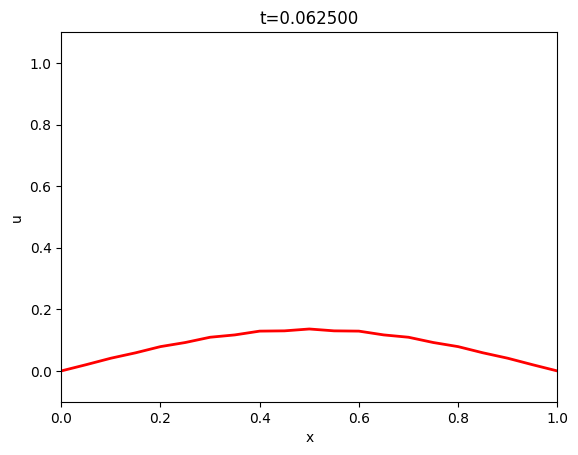

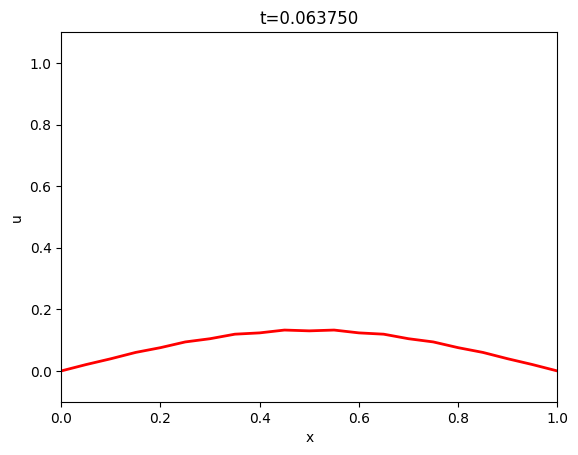

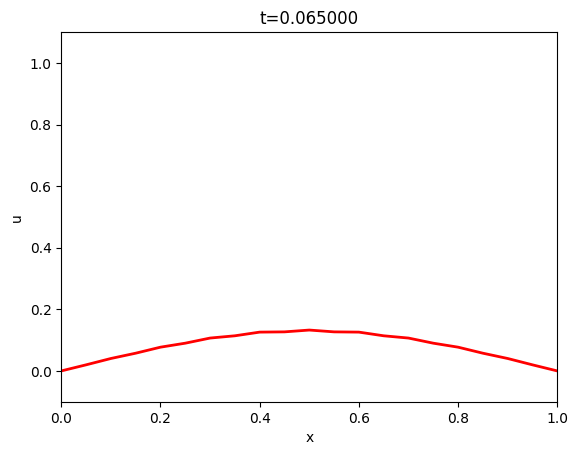

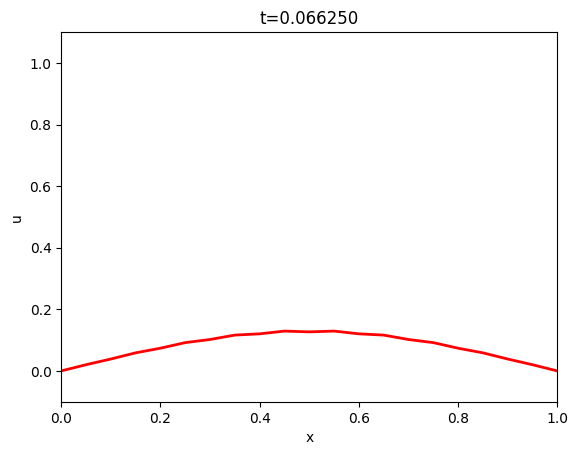

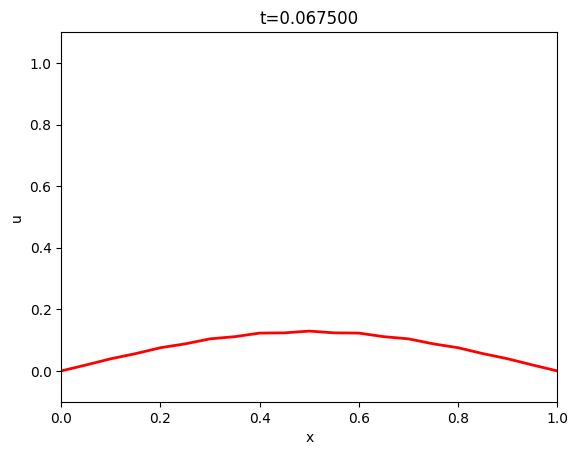

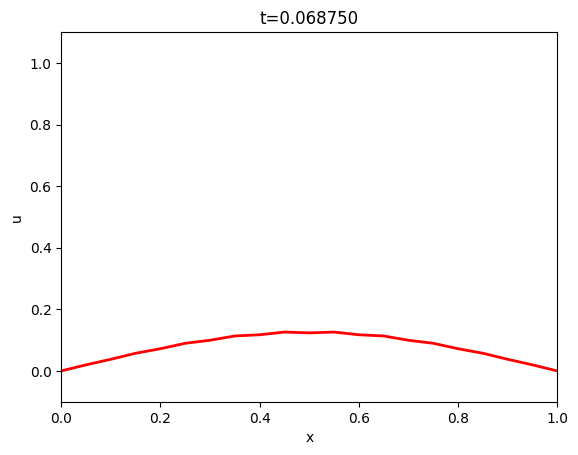

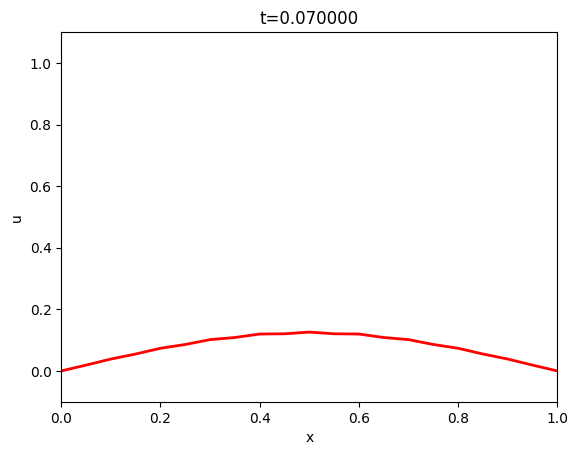

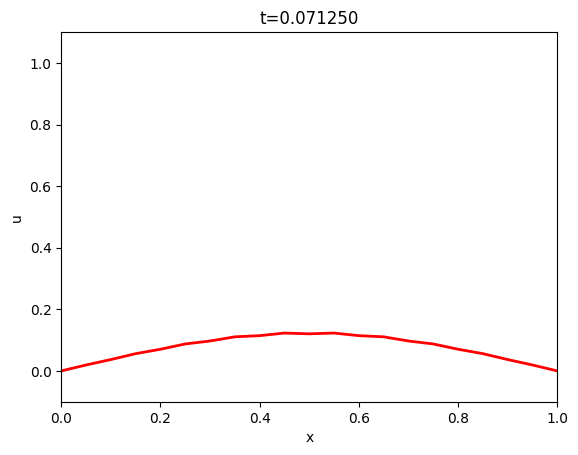

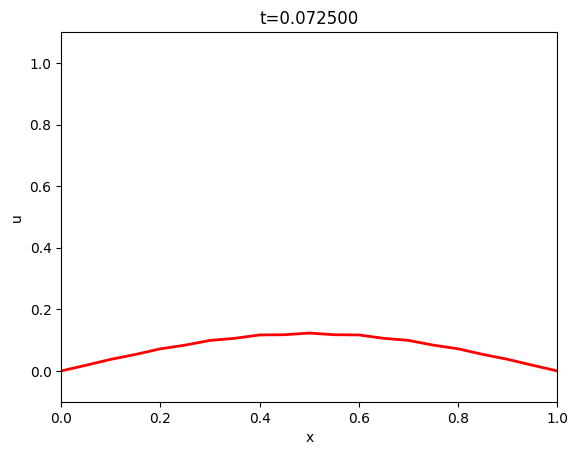

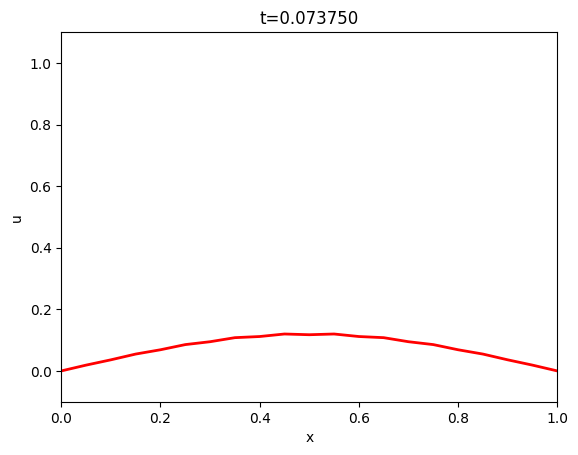

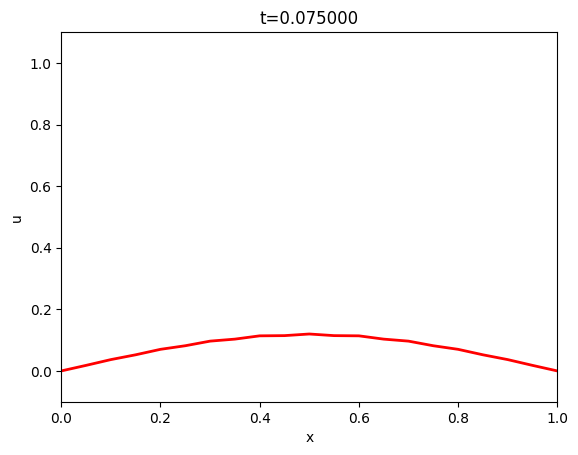

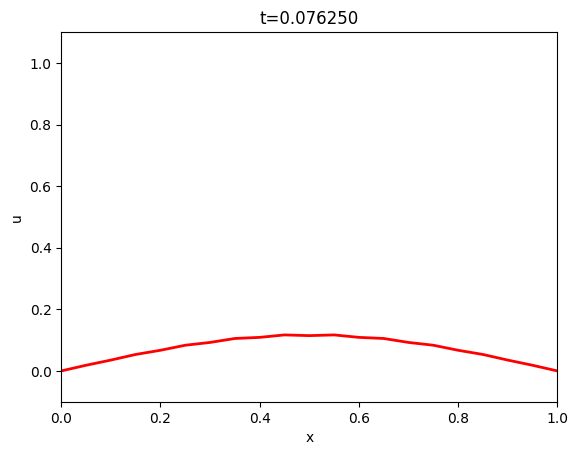

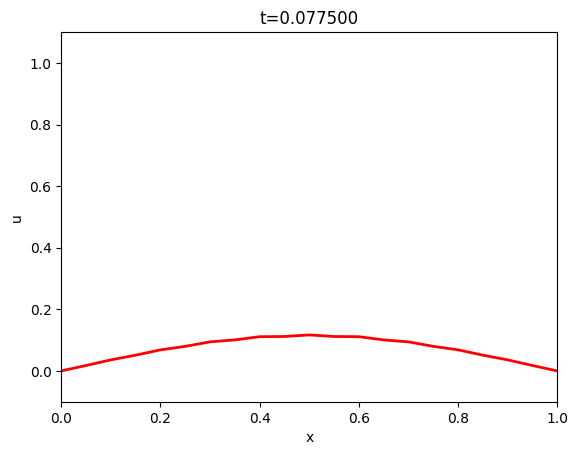

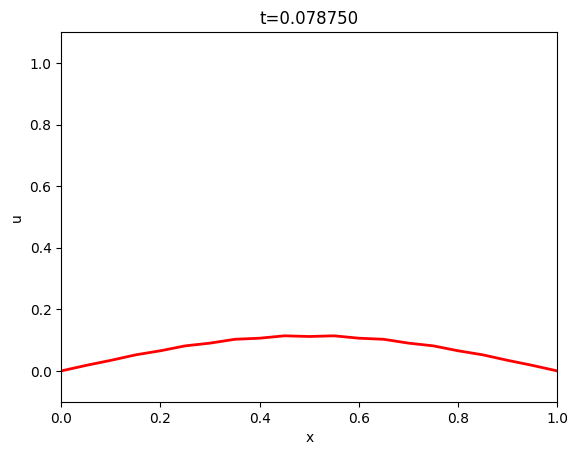

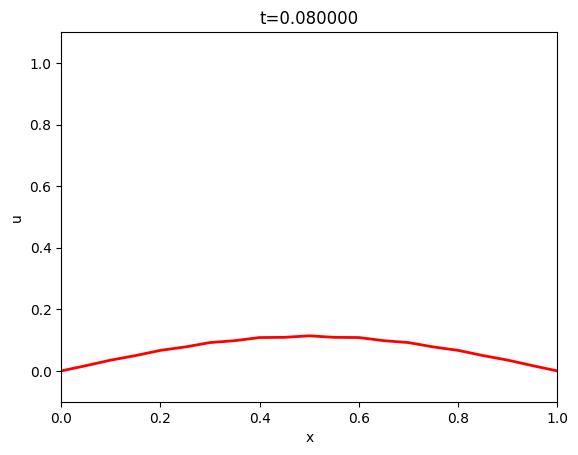

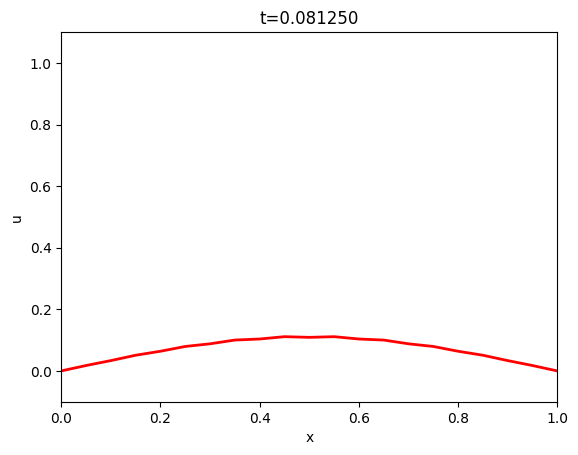

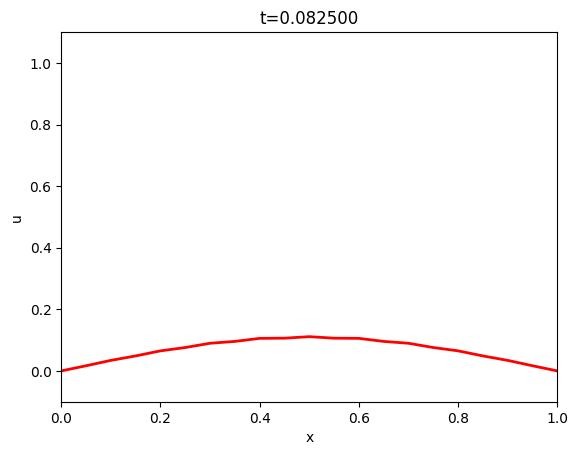

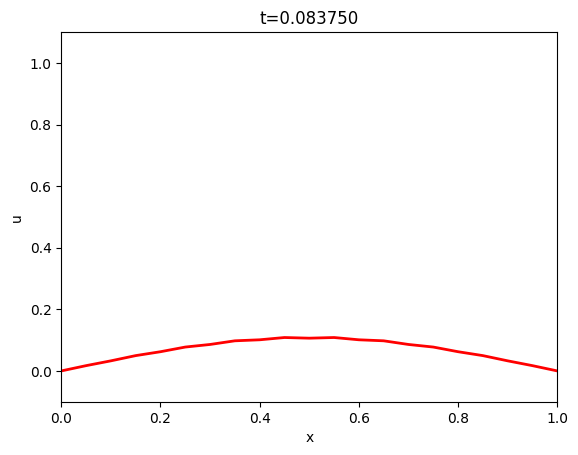

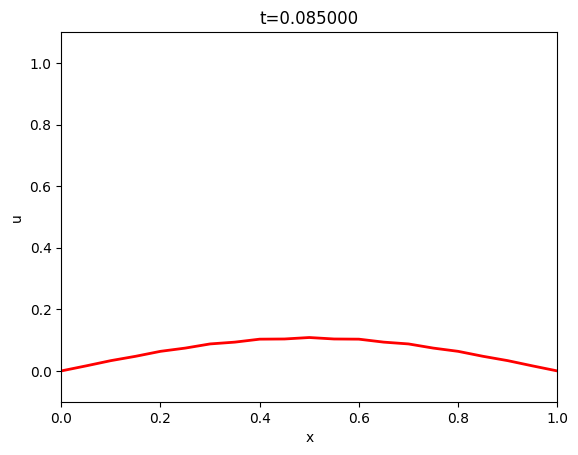

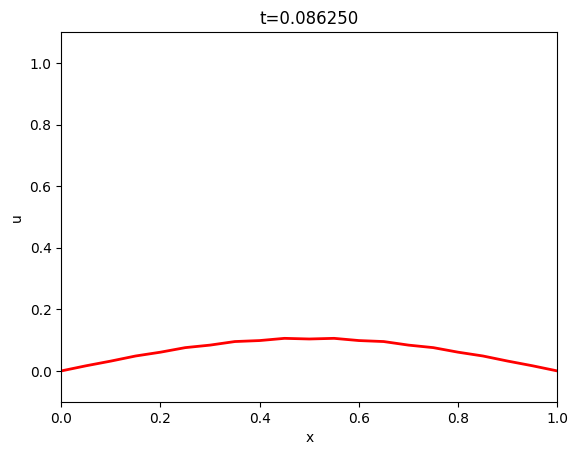

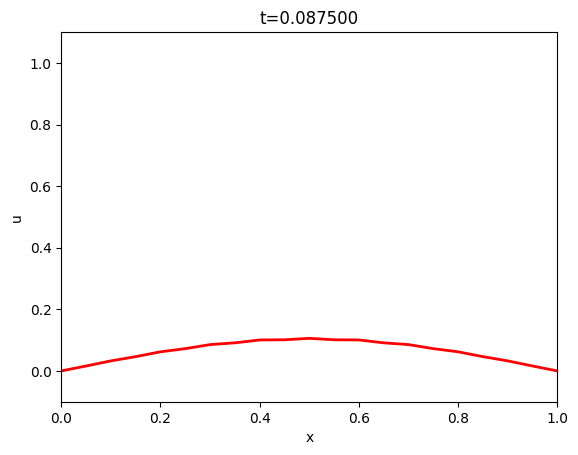

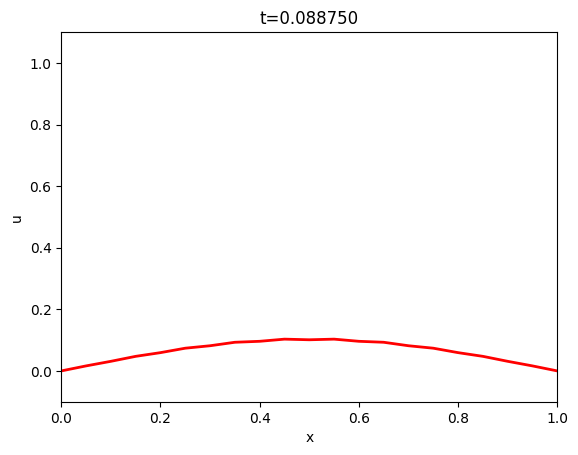

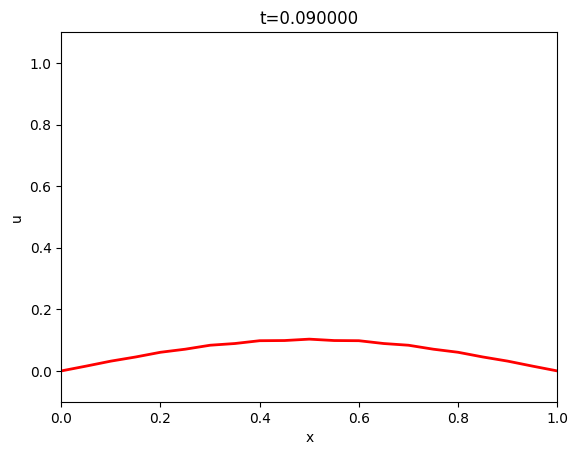

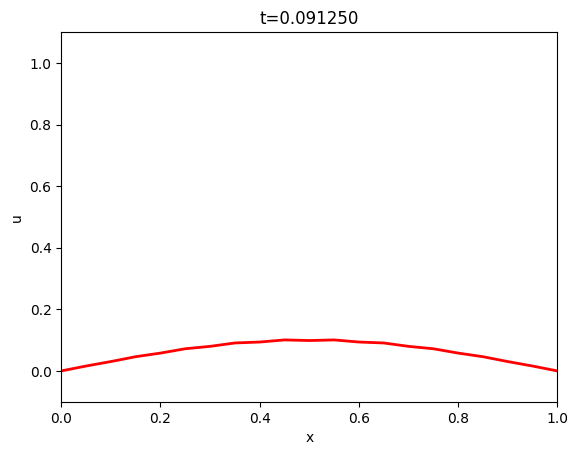

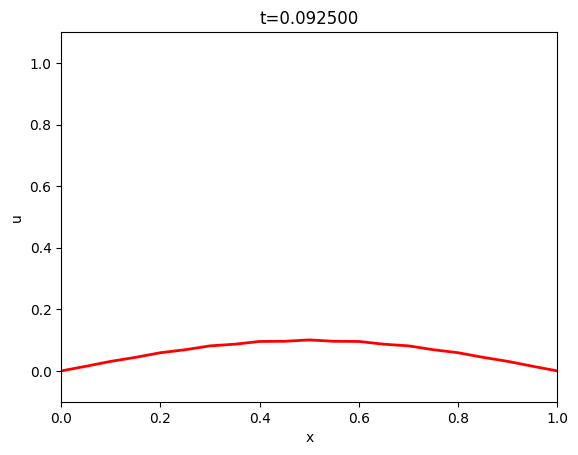

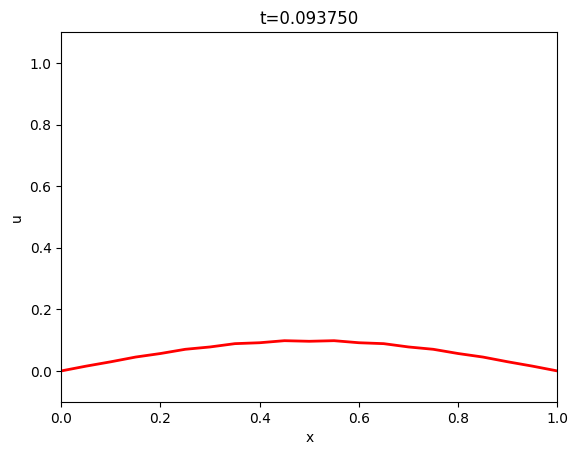

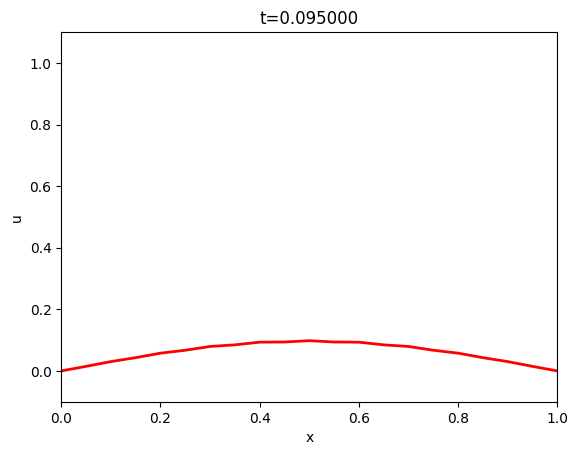

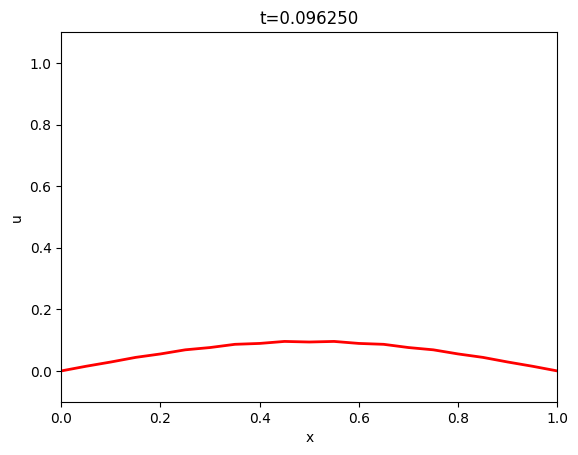

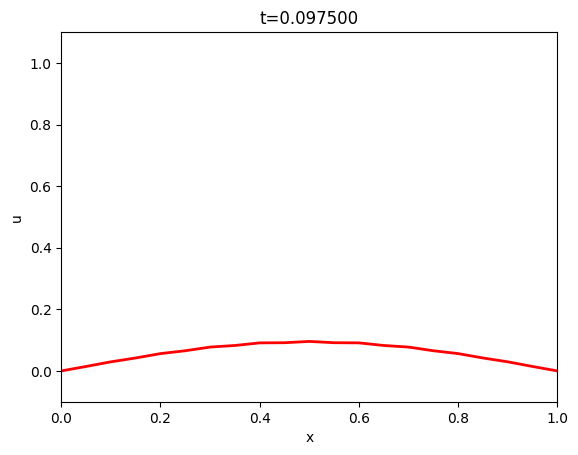

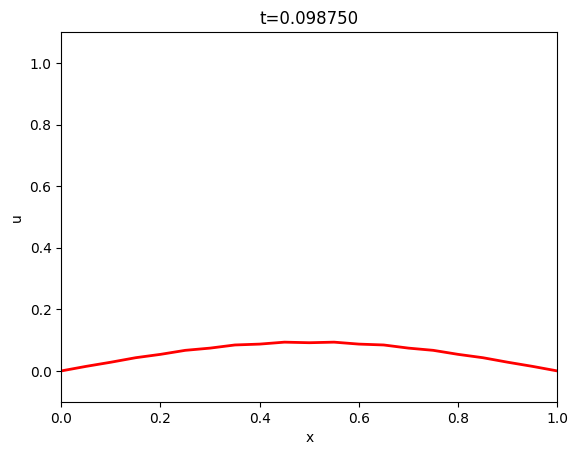

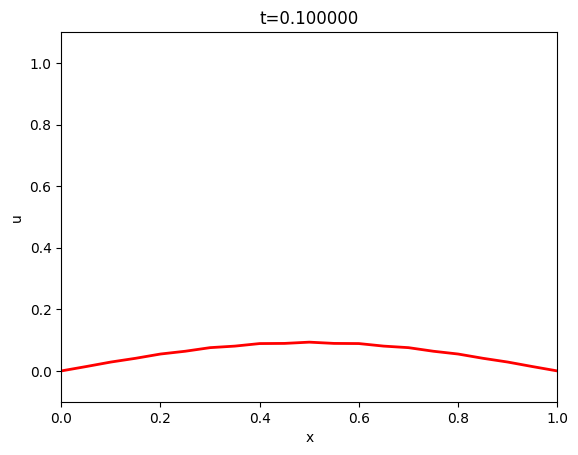

CPU time for Gaussian input: 39.393841759
PDF saved to 'output_plots_gaussian.pdf'


In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# I(x): Sets the initial concentration of the substance across the spatial domain.
# Diffusion Coefficient A: Controls the rate and extent of diffusion. Higher values mean faster and wider spreading.
# Source/Sink Function f(x, t): Represents external influences that add or remove the substance at different points and times in the domain.
# Spatial Domain L and Time Total T: Define the size of the space considered and the total time over which diffusion is observed.
# Discretization dx and dt: Spatial and temporal step sizes are crucial for numerical stability and accuracy. The Fourier number
# 𝐹 relates these with the diffusion coefficient to ensure stability through the condition and F≤0.5.


def solver_FE_simple(I, a, f, L, dt, F, T):
    """
    Simplest expression of the computational algorithm
    using the Forward Euler method and explicit Python loops.
    For this method F <= 0.5 for stability.

    Parameters:
    ----------
    I : function
        Initial condition function I(x)
    a : float
        Diffusion coefficient
    f : function
        Source term function f(x, t)
    L : float
        Length of the domain
    dt : float
        Time step
    F : float
        Courant-Friedrichs-Lewy (CFL) number for stability
    T : float
        Total simulation time

    Returns:
    -------
    u_n : numpy.ndarray
        Solution at final time step
    x : numpy.ndarray
        Spatial grid
    t : numpy.ndarray
        Time grid
    cpu_time : float
        CPU time taken for computation
    """
    t0 = time.process_time()  # For measuring the CPU time

    Nt = int(round(T / float(dt)))  #  Total number of time steps calculated by dividing the total time T by the time step dt.
    t = np.linspace(0, Nt * dt, Nt + 1)  # Mesh points in time and creates an array of time points from 0 to T with Nt + 1 points.
    dx = np.sqrt(a * dt / F)  # Spatial step size calculated using the stability condition related to F, ensuring that the Forward Euler method remains stable.
    Nx = int(round(L / dx))
    x = np.linspace(0, L, Nx + 1)  # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros(Nx + 1)  # Array to store the current concentration values.
    u_n = np.zeros(Nx + 1) # Array to store the concentration values from the previous time step, initialized using the initial condition.

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx + 1):
        u_n[i] = I(x[i])

    for n in range(0, Nt):
        # Compute u at inner mesh points
        for i in range(1, Nx):
            u[i] = u_n[i] + F * (u_n[i - 1] - 2 * u_n[i] + u_n[i + 1]) + \
                   dt * f(x[i], t[n])

        # Insert boundary conditions (Dirichlet boundary conditions)
        u[0] = 0
        u[Nx] = 0

        # Switch variables before next step
        u_n, u = u, u_n

    t1 = time.process_time()
    return u_n, x, t, t1 - t0  # u_n holds latest u , x - mesh point , t - time points , total computattion time.


def solver_FE(I, a, f, L, dt, F, T, user_action=None, version='scalar'):
    """
    Vectorized implementation of solver_FE_simple.

    Parameters:
    ----------
    I : function
        Initial condition function I(x)
    a : float
        Diffusion coefficient
    f : function
        Source term function f(x, t)
    L : float
        Length of the domain
    dt : float
        Time step
    F : float
        Courant-Friedrichs-Lewy (CFL) number for stability
    T : float
        Total simulation time
    user_action : function, optional
        Function to perform user-defined actions at each time step
    version : str, optional
        Version of the solver: 'scalar' or 'vectorized'

    Returns:
    -------
    cpu_time : float
        CPU time taken for computation
    """
    t0 = time.process_time() # for measuring the CPU time

    # Compute number of time steps
    Nt = int(round(T / float(dt)))
    t = np.linspace(0, Nt * dt, Nt + 1) # Mesh points in time

    # Compute spatial grid size
    dx = np.sqrt(a * dt / F)
    Nx = int(round(L / dx))
    x = np.linspace(0, L, Nx + 1) # Mesh points in space

    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    # Initialize arrays for solution
    u = np.zeros(Nx + 1)  # solution array
    u_n = np.zeros(Nx + 1) # solution at t-dt

    # Set initial condition
    for i in range(0, Nx + 1):
        u_n[i] = I(x[i])

    # User Action Callback: If provided, executes a user-defined action at t = 0 with the initial state as an argument.
    if user_action is not None:
        user_action(u_n, x, t, 0)

    # Time stepping loop
    # vectorized updates leverage NumPy's efficient array operations to process multiple grid points simultaneously.
    for n in range(0, Nt):
       # Update all inner points
        if version == 'scalar':
            for i in range(1, Nx):
                u[i] = u_n[i] + F * (u_n[i - 1] - 2 * u_n[i] + u_n[i + 1]) + dt * f(x[i], t[n])
        elif version == 'vectorized':
            u[1:Nx] = u_n[1:Nx] + F * (u_n[0:Nx - 1] - 2 * u_n[1:Nx] + u_n[2:Nx + 1]) + dt * f(x[1:Nx], t[n])
        else:
            raise ValueError('version=%s' % version)

        # Boundary conditions
        u[0] = 0
        u[Nx] = 0

        # Perform user-defined action at current time step if provided
        if user_action is not None:
            user_action(u, x, t, n + 1)

        # Update solution arrays
        u_n, u = u, u_n

    t1 = time.process_time()
    cpu_time = t1 - t0
    return cpu_time


def viz(I, a, L, dt, F, T, umin, umax, scheme='FE', animate=True, pdf_file='output_plots.pdf'):
    """
    Generate plots of the solution over time and save them in a PDF file.

    Parameters:
    ----------
    I : function
        Initial condition function I(x)
    a : float
        Diffusion coefficient
    L : float
        Length of the domain
    dt : float
        Time step
    F : float
        Courant-Friedrichs-Lewy (CFL) number for stability
    T : float
        Total simulation time
    umin : float
        Minimum value for y-axis in plots
    umax : float
        Maximum value for y-axis in plots
    scheme : str, optional
        Numerical scheme to use ('FE' in this case)
    animate : bool, optional
        Whether to animate the plots
    pdf_file : str, optional
        File name to save the PDF containing plots

    Returns:
    -------
    cpu_time : float
        CPU time taken for computation
    """
    pdf_pages = PdfPages(pdf_file)

    def plot_u(u, x, t, n):
        """
        Plot function for each time step.

        Parameters:
        ----------
        u : numpy.ndarray
            Solution array at current time step
        x : numpy.ndarray
            Spatial grid
        t : numpy.ndarray
            Time grid
        n : int
            Current time step index
        """
        fig, ax = plt.subplots()  # Create a new figure and axis for each plot
        ax.plot(x, u, 'r-', linewidth=2)
        ax.axis([0, L, umin, umax])
        ax.set_title('t=%f' % t[n])
        ax.set_xlabel('x')
        ax.set_ylabel('u')
        plt.pause(0.01)  # Pause to display the plot
        pdf_pages.savefig(fig)  # Save the current figure
        plt.close(fig)  # Close the current figure

    user_action = plot_u if animate else lambda u, x, t, n: None

    # Call solver_FE to compute the solution and generate plots
    cpu_time = solver_FE(I, a, lambda x, t: 0, L, dt, F, T, user_action=user_action)

    pdf_pages.close()

    return cpu_time


def plug(scheme='FE', F=0.5, Nx=50):
    """
    Run simulations with plug input profile (step function) and generate plots in a PDF file.

    Parameters:
    ----------
    scheme : str, optional
        Numerical scheme to use ('FE' in this case)
    F : float, optional
        Courant-Friedrichs-Lewy (CFL) number for stability
    Nx : int, optional
        Number of spatial grid points

    Returns:
    -------
    None
    """

    L = 1.
    a = 1.
    T = 0.1
    dx = L / Nx
    dt = F / a * dx ** 2

    def I(x):
        if abs(x - L / 2.0) > 0.1:
            return 0
        else:
            return 1

    pdf_file = 'output_plots_plug.pdf'
    cpu_time = viz(I, a, L, dt, F, T, umin=-0.1, umax=1.1, scheme=scheme, animate=True, pdf_file=pdf_file)
    print('CPU time for plug input:', cpu_time)
    print(f"PDF saved to '{pdf_file}'")


def gaussian(scheme='FE', F=0.5, Nx=50, sigma=0.05):
    """
    Run simulations with Gaussian input profile and generate plots in a PDF file.

    Parameters:
    ----------
    scheme : str, optional
        Numerical scheme to use ('FE' in this case)
    F : float, optional
        Courant-Friedrichs-Lewy (CFL) number for stability
    Nx : int, optional
        Number of spatial grid points
    sigma : float, optional
        Width parameter of the Gaussian input profile

    Returns:
    -------
    None
    """
    L = 1.
    a = 1.
    T = 0.1
    dx = L / Nx
    dt = F / a * dx ** 2

    def I(x):
        return np.exp(-0.5 * ((x - L / 2.0) ** 2) / sigma ** 2)

    pdf_file = 'output_plots_gaussian.pdf'
    cpu_time = viz(I, a, L, dt, F, T, umin=-0.1, umax=1.1, scheme=scheme, animate=True, pdf_file=pdf_file)
    print('CPU time for Gaussian input:', cpu_time)
    print(f"PDF saved to '{pdf_file}'")


def test_solvers():
    """
    Test the accuracy of solvers by comparing numerical solutions with an exact solution.

    Parameters:
    ----------
    None

    Returns:
    -------
    None
    """
    def u_exact(x, t):
        return x * (L - x) * 5 * t

    def I(x):
        return u_exact(x, 0)

    def f(x, t):
        return 5 * x * (L - x) + 10 * a * t

    a = 3.5
    L = 1.5
    Nx = 50
    F = 0.5
    dx = L / Nx
    dt = F / a * dx ** 2

    def compare(u, x, t, n):
        """
        Comparison function to check numerical solution against exact solution.

        Parameters:
        ----------
        u : numpy.ndarray
            Numerical solution at current time step
        x : numpy.ndarray
            Spatial grid
        t : numpy.ndarray
            Time grid
        n : int
            Current time step index

        Returns:
        -------
        None
        """
        u_e = u_exact(x, t[n])
        diff = np.abs(u_e - u).max()
        tol = 1E-10
        assert diff < tol, 'max diff: %g' % diff

    import functools
    s = functools.partial

    solvers = [
        s(solver_FE_simple, I=I, a=a, f=f, L=L, dt=dt, F=F, T=0.2),
        s(solver_FE, I=I, a=a, f=f, L=L, dt=dt, F=F, T=2, user_action=compare, version='scalar'),
        s(solver_FE, I=I, a=a, f=f, L=L, dt=dt, F=F, T=2, user_action=compare, version='vectorized'),
    ]

    u, x, t, cpu = solvers[0]()
    u_e = u_exact(x, t[-1])
    diff = np.abs(u_e - u).max()
    tol = 1E-10
    assert diff < tol, 'max diff solver_FE_simple: %g' % diff

    print("Exact and numerical solutions are within tolerance level", tol)

    for solver in solvers:
        solver()


test_solvers()
print("For plug input:")
plug(scheme='FE', F=0.5, Nx=20)
print('**************************')
print('For Gaussian input:')
gaussian(scheme='FE', F=0.5, Nx=20, sigma=0.05)
